# Coarse Wavelength division multiplexer using Cascade MZI

In [1]:
from functools import partial
from pathlib import Path
import gdsfactory as gf
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import sax
import meep as mp
import gplugins
import gplugins.gmeep as gm
import gplugins.tidy3d as gt
from gplugins.common.config import PATH
import inspect

Using MPI version 4.1, 1 processes
2025-12-07 03:11:00.640 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


In [2]:
fsr = 0.01
gap = 0.15
width = 0.45
wavelengths = np.linspace(1.45, 1.65, 50)
lda_c = wavelengths[wavelengths.size // 2]

pdk = gf.get_active_pdk()


layer_stack = pdk.get_layer_stack()
core = layer_stack.layers["core"]
clad = layer_stack.layers["clad"]
box = layer_stack.layers["box"]

layer_stack.layers.pop("substrate", None)

print(
    f"""Stack:
- {clad.material} clad with {clad.thickness}µm
- {core.material} clad with {core.thickness}µm
- {box.material} clad with {box.thickness}µm"""
)

Stack:
- sio2 clad with 3.0µm
- si clad with 0.22µm
- sio2 clad with 3.0µm


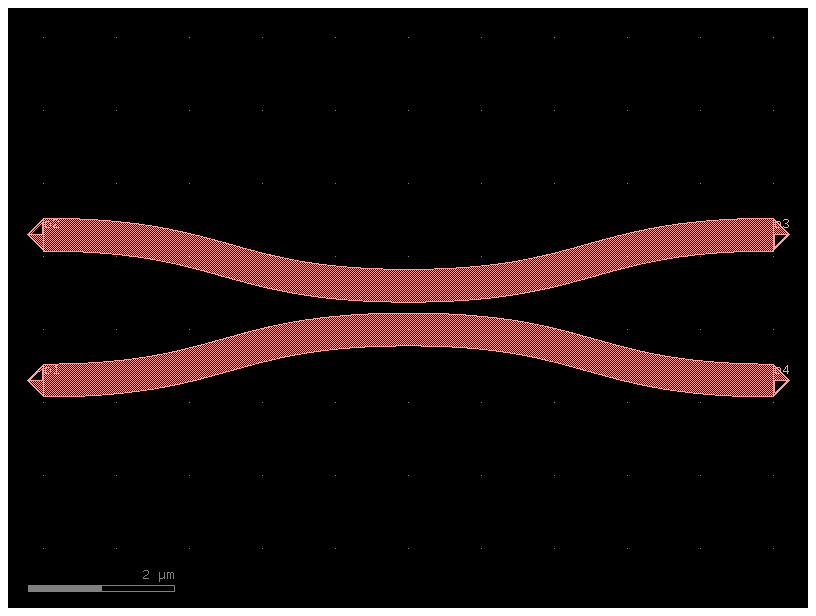

In [3]:
cross_section = pdk.get_cross_section("strip", width=width)

coupler_sc = partial(
    gf.components.coupler,
    gap=gap,
    dx=5,
    dy=2,
    cross_section=cross_section,
)  # Coupler Strip C-Band

coupler = coupler_sc(gap=gap, length=0.0)
coupler.draw_ports()
# coupler.show()  # show it in klayout
coupler.plot()  # plot it

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

resolution = 30
dpml = 1
pad = 1

sx = dpml + -(coupler.ports["o1"].x) + (coupler.ports["o4"].x) + dpml
sy = (
    dpml
    + pad
    + -(coupler.ports["o1"].y)
    + (coupler.ports["o4"].y)
    + pad
    + dpml
)

port_symmetries_coupler = {
    "o1": {
        "o1@0,o1@0": ["o2@0,o2@0", "o3@0,o3@0", "o4@0,o4@0"],
        "o2@0,o1@0": ["o1@0,o2@0", "o3@0,o4@0", "o4@0,o3@0"],
        "o3@0,o1@0": ["o1@0,o3@0", "o2@0,o4@0", "o4@0,o2@0"],
        "o4@0,o1@0": ["o1@0,o4@0", "o2@0,o3@0", "o3@0,o2@0"],
    }
}

Lets first do a 2.5D simualtion with effective mode approximation

In [4]:
core_material = gplugins.get_effective_indices(
    core_material=3.4777,
    clad_materialding=1.444,
    nsubstrate=1.444,
    thickness=0.22,
    wavelength=1.55,
    polarization="te",
)[0]

core_material

2.8494636999424405

# Full FDTD for couplers

Using meep for the simaultions

In [ ]:
sim_lengths = range(0,1,1)

mp.verbosity(0)
jobs = [
    dict(
        component=coupler_sc(gap=gap, length=length, cross_section=cross_section), #gf.components.straight(length=length+1), #
        filepath=Path(f'/home/ramprakash/Integrated_Tests/test_outputs/dc_{length}.npz'),
        port_source_names=['o1'],
        port_source_modes={'o1':[0]},
        port_modes=[0],
        xmargin_left=1,
        overwrite=False,
        xmargin_right=1,
        ymargin_top=1,
        ymargin_bot=1,
        tpml=dpml,
        resolution=30,
        wavelength_start=wavelengths[0],
        wavelength_stop=wavelengths[-1],
        wavelength_points=len(wavelengths),
        port_source_offset=0.2,
        port_monitor_offset=-0.1,
        distance_source_to_monitors=0.3,
        port_symmetries=port_symmetries_coupler,
        layer_stack=layer_stack,
        is_3d=False,
        material_name_to_meep=dict(si=core_material),
        # run=False
    )
    for length in sim_lengths
]
filepaths = gm.write_sparameters_meep_batch(
    jobs=jobs,
    cores_per_run=8,
    total_cores=32,
    lazy_parallelism=False,
    # filepaths='data/dc.npz'
)

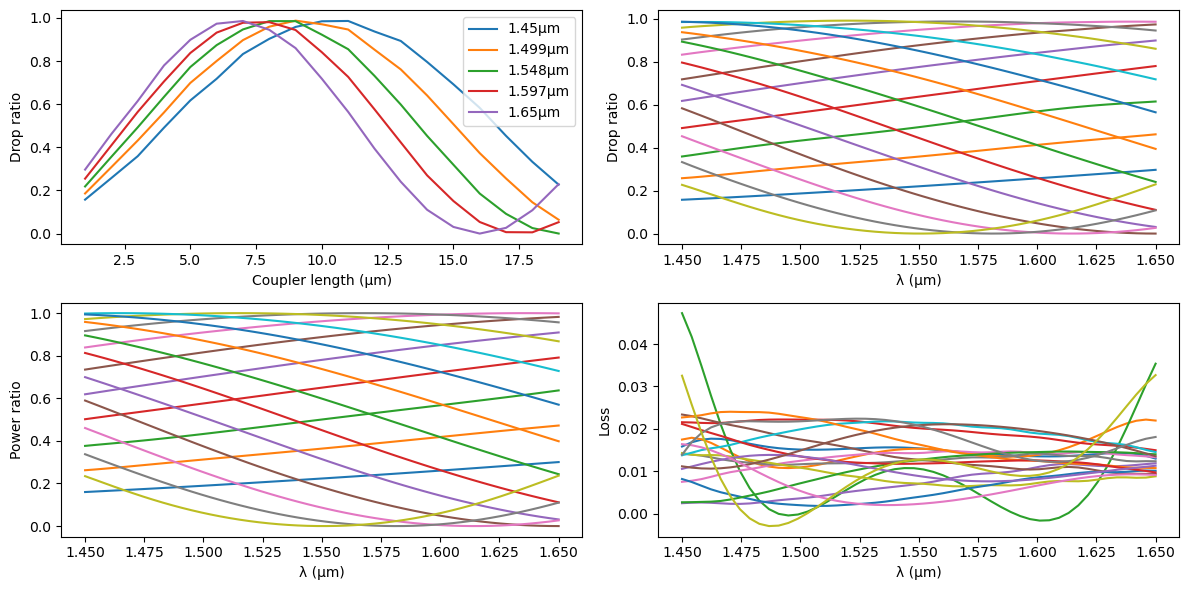

In [5]:
import re
sim_lengths = range(1,20,1)
folder = Path("/home/ramprakash/Integrated_Tests/test_outputs/")

# get files that start with dc_ and end with .npz, excluding "no_eff"
files = [
    f for f in folder.glob("dc_*.npz")
    if "no_eff" not in f.name
]

# sort by the number in filename (e.g., dc_14.npz → 14)
files = sorted(files, key=lambda f: int(re.search(r"\d+", f.stem).group()))

# load data in correct order
drop = np.array([np.abs(np.load(f)["o3@0,o1@0"])**2 for f in files])
thru = np.array([np.abs(np.load(f)["o4@0,o1@0"])**2 for f in files])
loss = 1 - (drop + thru)
sim_ratios = drop / (drop + thru)

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

for i in np.linspace(0, wavelengths.size - 1, 5, dtype=int):
    ax[0, 0].plot(
        sim_lengths, drop[:, i], label=f"{gf.snap.snap_to_grid(wavelengths[i])}µm"
    )

for i, length in enumerate(sim_lengths):
    ax[0, 1].plot(wavelengths, drop[i, :], label=f"{length}µm")
    ax[1, 0].plot(wavelengths, sim_ratios[i, :], label=f"{length}µm")
    ax[1, 1].plot(wavelengths, loss[i, :], label=f"{length}µm")

ax[0, 0].set_xlabel("Coupler length (µm)")
ax[0, 0].set_ylabel("Drop ratio")
ax[0, 1].set_xlabel("λ (µm)")
ax[0, 1].set_ylabel("Drop ratio")
ax[1, 0].set_xlabel("λ (µm)")
ax[1, 0].set_ylabel("Power ratio")
ax[1, 1].set_xlabel("λ (µm)")
ax[1, 1].set_ylabel("Loss")
ax[0, 0].legend()
# ax[0, 1].legend()
fig.tight_layout()

Fit funciton to calculate the length of DC for given power values 

In [6]:
def coupler_length(λ: float = 1.55, power_ratio: float = 0.5):
    i0 = np.argmin(np.abs(wavelengths - λ))
    i1 = min(i0 + 1, len(wavelengths) - 1) if λ > wavelengths[i] else max(i0 - 1, 0)
    if i1 != i0:
        pr = (
            sim_ratios[:, i0] * (wavelengths[i1] - λ)
            + sim_ratios[:, i1] * (λ - wavelengths[i0])
        ) / (wavelengths[i1] - wavelengths[i0])
    else:
        pr = sim_ratios[:, i0]
    y = pr - power_ratio
    root_indices = np.flatnonzero(y[1:] * y[:-1] <= 0)
    if len(root_indices) == 0:
        return sim_lengths[np.argmin(np.abs(y))]
    j = root_indices[0]
    return (
        sim_lengths[j] * (pr[j + 1] - power_ratio)
        + sim_lengths[j + 1] * (power_ratio - pr[j])
    ) / (pr[j + 1] - pr[j])


power_ratios = [0.50, 0.13, 0.12, 0.50, 0.25]
lengths = [gf.snap.snap_to_grid(coupler_length(lda_c, pr)) for pr in power_ratios]
print("Power ratios:", power_ratios)
print("Lengths:", lengths)

Power ratios: [0.5, 0.13, 0.12, 0.5, 0.25]
Lengths: [2.976, 16.484, 16.59, 2.976, 1.178]


Calcauting the sparamters for these lengths

In [ ]:
# sim_lengths = range(0,1,1)
mp.verbosity(0)
jobs = [
    dict(
        component=coupler_sc(gap=gap, length=length, cross_section=cross_section), #gf.components.straight(length=length+1), #
        filepath=Path(f'/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_{length}.npz'),
        port_source_names=['o1'],
        port_source_modes={'o1':[0]},
        port_modes=[0],
        xmargin_left=1,
        overwrite = False, # overwrite
        xmargin_right=1,
        ymargin_top=1,
        ymargin_bot=1,
        tpml=dpml,
        resolution=30,
        wavelength_start=wavelengths[0],
        wavelength_stop=wavelengths[-1],
        wavelength_points=len(wavelengths),
        port_source_offset=0.2,
        port_monitor_offset=-0.1,
        distance_source_to_monitors=0.3,
        port_symmetries=port_symmetries_coupler,
        layer_stack=layer_stack,
        is_3d=False,
        material_name_to_meep=dict(si=core_material),
        # run=False
    )
    for length in lengths
]
filepaths = gm.write_sparameters_meep_batch(
    jobs=jobs,
    cores_per_run=6,
    total_cores=32,
    lazy_parallelism=False,
    # filepaths='data/dc.npz'
)

In [ ]:
s_drop_list = np.array([np.load(s)["o3@0,o1@0"] for s in filepaths]) # Remember to sort
s_thru_list = np.array([np.load(s)["o4@0,o1@0"] for s in filepaths])
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
errors = []
i = wavelengths.size // 2

for pr, sp_drop, sp_thru in zip(power_ratios, s_drop_list, s_thru_list):
    drop = np.abs(sp_drop) ** 2
    thru = np.abs(sp_thru) ** 2

    lda_c == wavelengths[i]
    errors.append(drop[i] / (thru[i] + drop[i]) - pr)

    ax[0].plot(wavelengths, thru, label=f"{1 - pr}")
    ax[1].plot(wavelengths, drop, label=f"{pr}")
    ax[2].plot(wavelengths, 1 - thru - drop)

ax[0].set_ylabel("Thru ratio")
ax[1].set_ylabel("Drop ratio")
ax[2].set_ylabel("Loss")
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].legend()
ax[1].legend()
fig.tight_layout()
print(errors)

# FIXME: I see that the longer lengths highly dispersive with wavelength. Smaller lengths could do the same. Or something else is wrong

Clacualted the path length for a given FSR 

2025-12-07 03:11:39.492 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from /home/ramprakash/.gdsfactory/modes/Waveguide_fef714a91475d5ea.npz.
ne = 2.4241435358010763, ng = 4.271061538394366
Path difference (ΔL = 14.099718968513637, Lπ = 0.3201214765968152): (np.float64(14.099718968513637), np.float64(28.199437937027273), np.float64(-28.519559413624087), np.float64(-28.199437937027273))


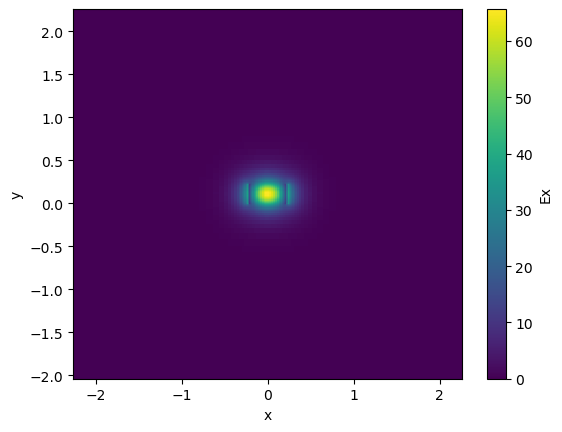

In [7]:
def mzi_path_difference(waveguide: gt.modes.Waveguide, group_index: float, fsr: float):
    return waveguide.wavelength**2 / (fsr * group_index)


nm = 1e-3

mode_solver_specs = dict(
    core_material=core.material,
    clad_material=clad.material,
    core_width=width,
    core_thickness=core.thickness,
    box_thickness=min(2.0, box.thickness),
    clad_thickness=min(2.0, clad.thickness),
    side_margin=2.0,
    num_modes=2,
    grid_resolution=20,
    precision="double",
)

waveguide_solver = gt.modes.Waveguide(
    wavelength=lda_c, **mode_solver_specs, group_index_step=True
)

waveguide_solver.plot_field(field_name="Ex", mode_index=0)
ng = waveguide_solver.n_group[0]
ne = waveguide_solver.n_eff[0].real
print(f"ne = {ne}, ng = {ng}")
fsr_s1 = 40e-3  # µm
length_delta = mzi_path_difference(waveguide_solver, ng, fsr_s1)
length_pi = lda_c / (2 * ne)
mzi_deltas = (
    length_delta,
    2 * length_delta,
    -length_pi - 2 * length_delta,
    -2 * length_delta,
)
print(f"Path difference (ΔL = {length_delta}, Lπ = {length_pi}):", mzi_deltas)

Finally using the lengths and dc we create a cacased mzi layout in gdsfactory

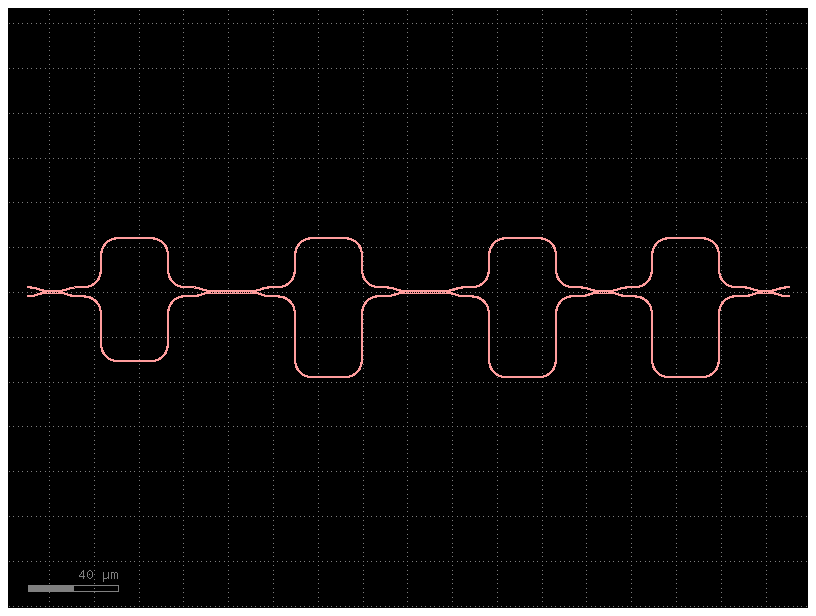

In [8]:
lengths = [2.976, 16.484, 16.59, 2.976, 1.178]
layout = gf.c.mzi_lattice(
    coupler_gaps=(gap,) * len(lengths),
    coupler_lengths=tuple(lengths),
    delta_lengths=tuple([abs(x) for x in mzi_deltas]),
    cross_section='strip',
)
layout.plot()

# Compact models

## Straight waveguide

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/numpy/_core/getlimits.py:559: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/numpy/_core/getlimits.py:91: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


2025-12-07 03:11:47.755 | INFO     | gplugins.tidy3d.modes:_data:266 - load data from /home/ramprakash/.gdsfactory/modes/Waveguide_2eaa822cd5c7cfd7.npz.


Text(0, 0.5, 'n_eff')

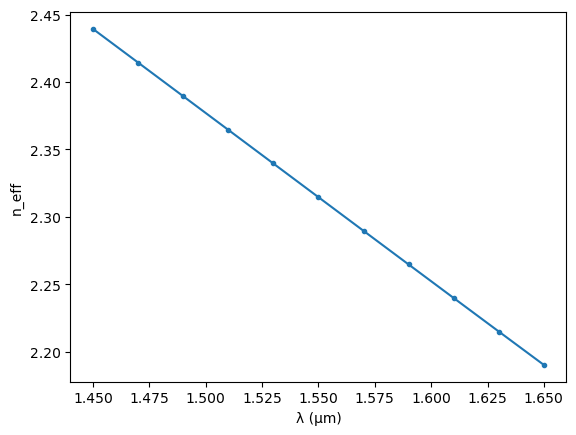

In [9]:
# calulating neff using tidy3d mode solver - free
straight_wavelengths = jnp.linspace(wavelengths[0], wavelengths[-1], 11)
straight_neffs = np.empty(straight_wavelengths.size, dtype=complex)

waveguide_solver = gt.modes.Waveguide(
    wavelength=list(straight_wavelengths), **mode_solver_specs
)
straight_neffs = waveguide_solver.n_eff[:, 0]

plt.plot(straight_wavelengths, straight_neffs.real, ".-")
plt.xlabel("λ (µm)")
plt.ylabel("n_eff")

Sax compact model

In [10]:
@jax.jit
def complex_interp(xs, x, y):
    ys_mag = jnp.interp(xs, x, jnp.abs(y))
    ys_phase = jnp.interp(xs, x, jnp.unwrap(jnp.angle(y)))
    return ys_mag * jnp.exp(1j * ys_phase)


@jax.jit
def straight_model(wl=np.linspace(1.45, 1.65, 50), length: float = 1.0):
    n_eff = complex_interp(wl, straight_wavelengths, straight_neffs.real)
    s21 = jnp.exp(2j * jnp.pi * n_eff * length / wl)
    zero = jnp.zeros_like(wl)
    return {
        ("o1", "o1"): zero,
        ("o1", "o2"): s21,
        ("o2", "o1"): s21,
        ("o2", "o2"): zero,
    }


straight_model(wl=1.55)

{('o1', 'o1'): Array(0., dtype=float64, weak_type=True),
 ('o1', 'o2'): Array(-0.99911567+0.04204618j, dtype=complex128),
 ('o2', 'o1'): Array(-0.99911567+0.04204618j, dtype=complex128),
 ('o2', 'o2'): Array(0., dtype=float64, weak_type=True)}

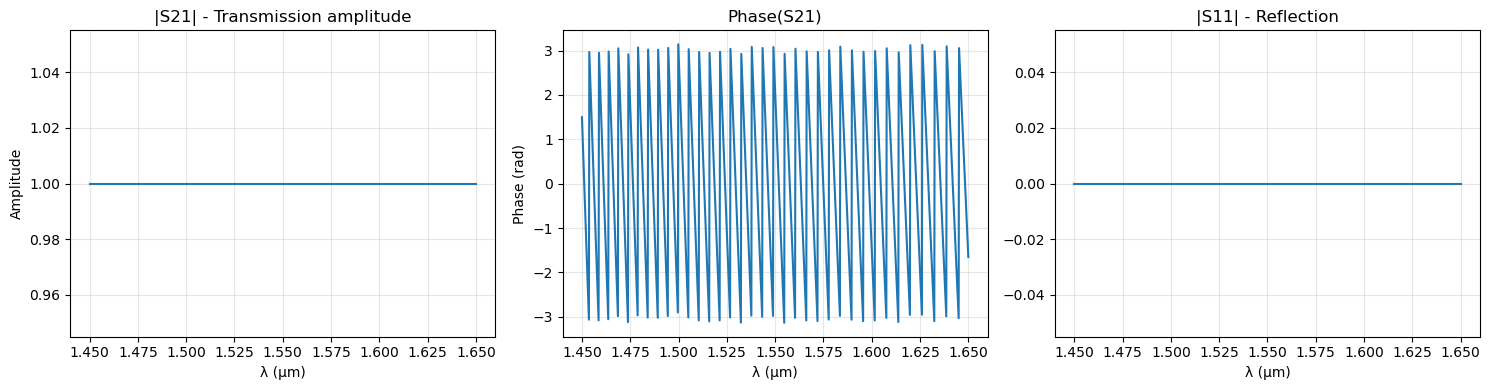

In [11]:
# Test straight waveguide
wl_test = np.linspace(1.45, 1.65, 1000)
# test_straight = straight_model(length=100.0)
s_straight = straight_model(wl=wl_test, length=100.0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(wl_test, np.abs(s_straight[("o1", "o2")]))
axes[0].set_title('|S21| - Transmission amplitude')
axes[0].set_ylabel('Amplitude')

axes[1].plot(wl_test, np.angle(s_straight[("o1", "o2")]))
axes[1].set_title('Phase(S21)')
axes[1].set_ylabel('Phase (rad)')

axes[2].plot(wl_test, np.abs(s_straight[("o1", "o1")]))
axes[2].set_title('|S11| - Reflection')

for ax in axes:
    ax.set_xlabel('λ (µm)')
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

## Bend waveguides

For bends we will use the full s matrix calculations again

In [12]:
def bend_model(cross_section: gf.typings.CrossSectionSpec = "strip", wavelengths: list =np.linspace(1.45, 1.65, 50)):
    component = gf.components.bend_euler(cross_section=cross_section)
    s = gm.write_sparameters_meep(
        component=component,
        filepath=Path(f'/home/ramprakash/Integrated_Tests/test_outputs/bend_wg.npz'),
        layer_stack=layer_stack,
        xmargin_left=1,
        overwrite=False, # overwrite
        xmargin_right=1,
        ymargin_top=1,
        ymargin_bot=1,
        tpml=dpml,
        resolution=30,
        wavelength_start=wavelengths[0],
        wavelength_stop=wavelengths[-1],
        wavelength_points=len(wavelengths),
        port_source_offset=0.2,
        port_monitor_offset=-0.1,
        distance_source_to_monitors=0.3,
        is_3d=False,
        port_symmetries=gm.port_symmetries.port_symmetries_1x1,
        material_name_to_meep=dict(si=core_material),
    )
    # wavelengths = s.pop("wavelengths")

    @jax.jit
    def _model(wl=1.55):
        s11 = complex_interp(wl, wavelengths, s["o1@0,o1@0"])
        s21 = complex_interp(wl, wavelengths, s["o2@0,o1@0"])
        return {
            ("o1", "o1"): s11,
            ("o1", "o2"): s21,
            ("o2", "o1"): s21,
            ("o2", "o2"): s11,
        }

    return _model


bend_model(cross_section=cross_section, wavelengths=wavelengths)()

2025-12-07 03:11:58.227 | INFO     | gplugins.gmeep.write_sparameters_meep:write_sparameters_meep:397 - Simulation loaded from PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/bend_wg.npz')


{('o1', 'o1'): Array(-0.0078387-0.00469722j, dtype=complex128),
 ('o1', 'o2'): Array(0.92702953+0.37199991j, dtype=complex128),
 ('o2', 'o1'): Array(0.92702953+0.37199991j, dtype=complex128),
 ('o2', 'o2'): Array(-0.0078387-0.00469722j, dtype=complex128)}

Circuit model test for the bend

2025-12-07 03:12:02.052 | INFO     | gplugins.gmeep.write_sparameters_meep:write_sparameters_meep:397 - Simulation loaded from PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/bend_wg.npz')


Text(0.5, 0, 'λ (µm)')

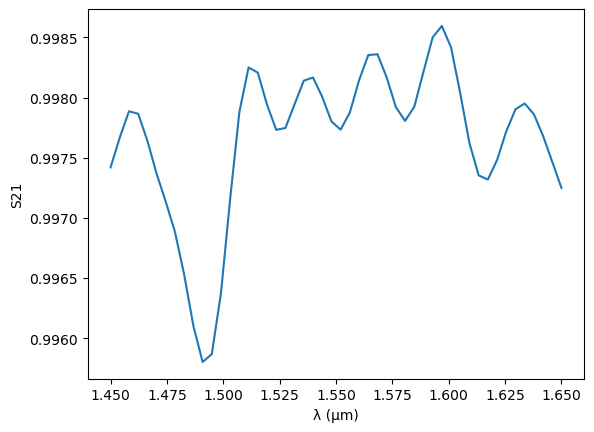

In [13]:
c = gf.Component()
ref = c.add_ref(gf.components.bend_euler(cross_section=cross_section))
c.add_ports(ref.ports)
x, _ = sax.circuit(
    c.get_netlist(), {"bend_euler": bend_model(cross_section=cross_section)}
)

s = x(wl=wavelengths)
plt.plot(wavelengths, jnp.abs(s[("o1", "o2")]) ** 2)
plt.ylabel("S21")
plt.xlabel("λ (µm)")

## Terminator models

Building terminator model which absorbers all the light

In [14]:
def terminator_model(wl=1.55, **kwargs):
    """Perfect absorber - no reflections, all power absorbed"""
    wl = jnp.atleast_1d(wl)
    zero = jnp.zeros_like(wl)
    
    if wl.shape == (1,):
        zero = jnp.squeeze(zero)
    
    return {
        ("o1", "o1"): zero,  # No reflection
        ("o1", "o2"): zero,  # No transmission (absorbed)
        ("o2", "o1"): zero,
        ("o2", "o2"): zero,
    }

## Directional coupler models

Building a compact coupler model from full s-parameters 

In [15]:
def coupler_model(
    gap: float = 0.15,
    length: float = 1.0,
    dx: float = 5.0,
    dy: float = 2.0,
    cross_section: gf.typings.CrossSectionSpec = "strip",
    wavelengths: list =np.linspace(1.45, 1.65, 50)
):
    component = coupler_sc(
        gap=gap,
        length=length,
        dx=dx,
        dy=dy,
    )
    # separation = 2.0
    # bend_factor = 4.0
    s = gm.write_sparameters_meep_mpi(
        component,
        cores=8,
        xmargin_left=1,
        xmargin_right=1,
        ymargin_top=1,
        ymargin_bot=1,
        port_source_names=['o1'],
        port_source_modes={'o1':[0]},
        port_modes=[0],
        filepath=Path(f'/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_{length}.npz'),
        tpml=dpml,
        resolution=resolution,
        wavelength_start=wavelengths[0],
        wavelength_stop=wavelengths[-1],
        wavelength_points=len(wavelengths),
        port_source_offset=0.2,
        port_monitor_offset=-0.1,
        distance_source_to_monitors=0.3,
        port_symmetries=port_symmetries_coupler,
        layer_stack=layer_stack,
        material_name_to_meep=dict(si=core_material),
        is_3d=False,
        overwrite=False,
        run=False
        )
    # wavelengths = s.pop("wavelengths")

    @jax.jit
    def _model(wl=1.55):
        s11 = complex_interp(wl, wavelengths, np.load(s)["o1@0,o1@0"])
        s21 = complex_interp(wl, wavelengths, np.load(s)["o2@0,o1@0"])
        s31 = complex_interp(wl, wavelengths, np.load(s)["o3@0,o1@0"])
        s41 = complex_interp(wl, wavelengths, np.load(s)["o4@0,o1@0"])
        return {
            ("o1", "o1"): s11,
            ("o1", "o2"): s21,
            ("o1", "o3"): s31,
            ("o1", "o4"): s41,
            ("o2", "o1"): s21,
            ("o2", "o2"): s11,
            ("o2", "o3"): s41,
            ("o2", "o4"): s31,
            ("o3", "o1"): s31,
            ("o3", "o2"): s41,
            ("o3", "o3"): s11,
            ("o3", "o4"): s21,
            ("o4", "o1"): s41,
            ("o4", "o2"): s31,
            ("o4", "o3"): s21,
            ("o4", "o4"): s11,
        }

    return _model


coupler_model(
    gap=gap,
    length=lengths[0],
    cross_section=cross_section,
    wavelengths=wavelengths
)()

2025-12-07 03:12:10.189 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.976.npz') already exists


{('o1', 'o1'): Array(-0.00039673-0.00487822j, dtype=complex128),
 ('o1', 'o2'): Array(0.00611158+0.00253545j, dtype=complex128),
 ('o1', 'o3'): Array(0.61869085-0.32597752j, dtype=complex128),
 ('o1', 'o4'): Array(-0.32943778-0.62498716j, dtype=complex128),
 ('o2', 'o1'): Array(0.00611158+0.00253545j, dtype=complex128),
 ('o2', 'o2'): Array(-0.00039673-0.00487822j, dtype=complex128),
 ('o2', 'o3'): Array(-0.32943778-0.62498716j, dtype=complex128),
 ('o2', 'o4'): Array(0.61869085-0.32597752j, dtype=complex128),
 ('o3', 'o1'): Array(0.61869085-0.32597752j, dtype=complex128),
 ('o3', 'o2'): Array(-0.32943778-0.62498716j, dtype=complex128),
 ('o3', 'o3'): Array(-0.00039673-0.00487822j, dtype=complex128),
 ('o3', 'o4'): Array(0.00611158+0.00253545j, dtype=complex128),
 ('o4', 'o1'): Array(-0.32943778-0.62498716j, dtype=complex128),
 ('o4', 'o2'): Array(0.61869085-0.32597752j, dtype=complex128),
 ('o4', 'o3'): Array(0.00611158+0.00253545j, dtype=complex128),
 ('o4', 'o4'): Array(-0.00039673-

Using the netlist for different lengths and model for the lengths

2025-12-05 03:05:26.504 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.02.npz') already exists


2025-12-05 03:05:27.198 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.115.npz') already exists
2025-12-05 03:05:27.878 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_1.189.npz') already exists
2025-12-05 03:05:28.528 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists


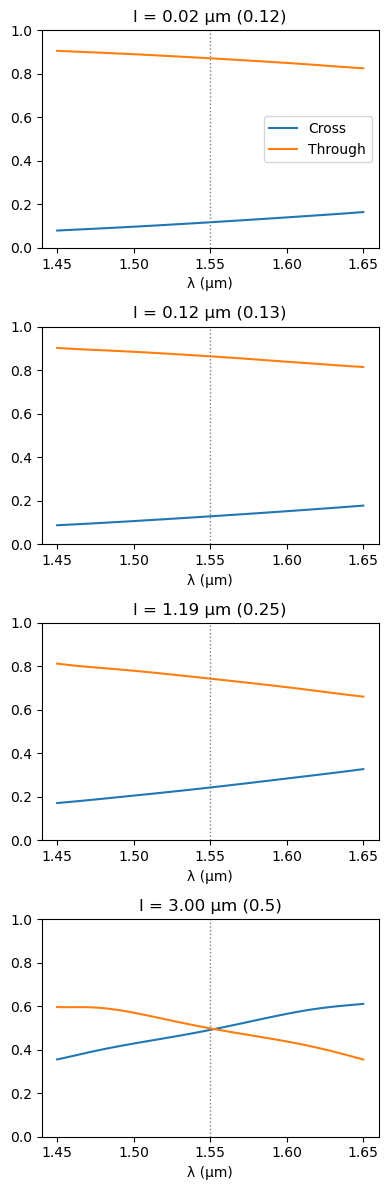

In [74]:
import inspect


def patch_netlist(netlist, models, models_to_patch):
    instances = netlist["instances"]
    for name in instances:
        model = instances[name]
        if model["component"] in models_to_patch:
            component = model["component"]
            i = 0
            new_component = f"{component}_v{i}"
            while new_component in models:
                i += 1
                new_component = f"{component}_v{i}"
            settings = model["settings"]
            settings_fitered = {
                k: v
                for k, v in settings.items()
                if k in inspect.signature(models_to_patch[component]).parameters
            }
            models[new_component] = models_to_patch[model["component"]](
                **settings_fitered
            )
            del model["settings"]
            model["component"] = new_component
    return netlist, models


pl_set = sorted(set(zip(power_ratios, lengths)))
fig, ax = plt.subplots(len(pl_set), 1, figsize=(4, 3 * len(pl_set)))

for i, (pr, length) in enumerate(pl_set):
    c = gf.Component()
    ref = c.add_ref(
        coupler_sc(
            gap,
            length,
        )
    )
    c.add_ports(ref.ports)
    netlist, models = patch_netlist(c.get_netlist(), {}, {"coupler": coupler_model})
    x, _ = sax.circuit(netlist, models)
    s = x(wl=wavelengths)
    ax[i].plot(wavelengths, jnp.abs(s[("o1", "o3")]) ** 2, label="Cross")
    ax[i].plot(wavelengths, jnp.abs(s[("o1", "o4")]) ** 2, label="Through")
    ax[i].axvline(lda_c, c="tab:gray", ls=":", lw=1)
    ax[i].set_ylim(0, 1)
    ax[i].set_xlabel("λ (µm)")
    ax[i].set_title(f"l = {length:.2f} µm ({pr})")

ax[0].legend()
fig.tight_layout()

# Circuit simualtions

Circuit simaultion of single MZI's with differnt path lenght and DCs

2025-12-07 04:16:23.745 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 04:16:23.747 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.115.npz') already exists


2025-12-07 04:16:25.118 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.115.npz') already exists
2025-12-07 04:16:25.119 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.02.npz') already exists
2025-12-07 04:16:26.450 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.02.npz') already exists
2025-12-07 04:16:26.451 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 04:16:27.707 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPa

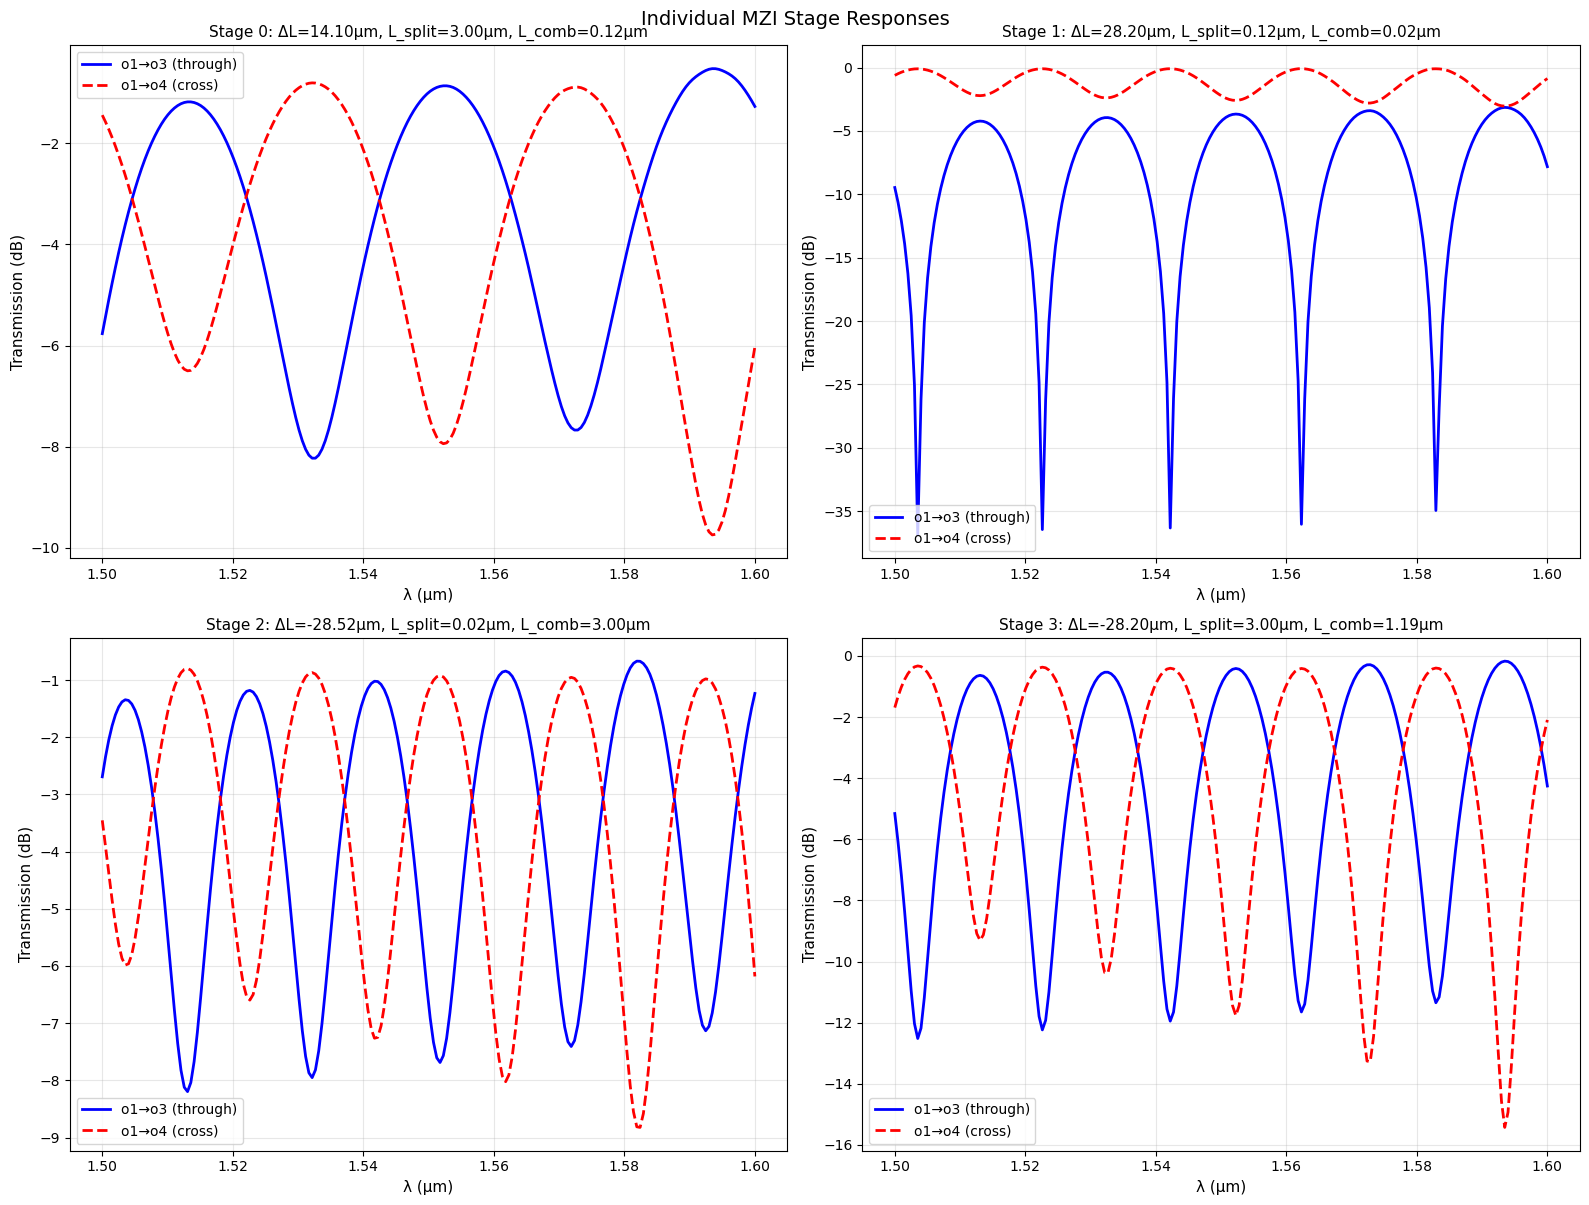

In [85]:
def patch_netlist(netlist, models, models_to_patch):
    instances = netlist["instances"]
    for name in instances:
        model = instances[name]
        if model["component"] in models_to_patch:
            component = model["component"]
            i = 0
            new_component = f"{component}_v{i}"
            while new_component in models:
                i += 1
                new_component = f"{component}_v{i}"
            settings = model["settings"]
            settings_filtered = {
                k: v
                for k, v in settings.items()
                if k in inspect.signature(models_to_patch[component]).parameters
            }
            models[new_component] = models_to_patch[model["component"]](
                **settings_filtered
            )
            del model["settings"]
            model["component"] = new_component
    return netlist, models

# lengths = [2.976, 16.484, 16.59, 2.976, 1.178] # 
lengths =  [2.996, 0.115, 0.02, 2.996, 1.189]

# Wavelength range for simulation
wl_test = np.linspace(1.50, 1.60, 200)

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Loop through each MZI stage
for stage_idx in range(4):
   
    # Get coupler indices for this MZI
    splitter_idx = stage_idx
    combiner_idx = stage_idx + 1
    
    # Create couplers
    splitter_coupler = gf.components.coupler(
        gap=gap,
        length=lengths[splitter_idx],
        cross_section='strip',
    )
    
    combiner_coupler = gf.components.coupler(
        gap=gap,
        length=lengths[combiner_idx],
        cross_section='strip',
    )
    
    # Create MZI
    single_mzi = gf.components.mzi2x2_2x2_phase_shifter(
        delta_length=np.abs(mzi_deltas[stage_idx]),
        length_x=0.5,
        length_y=1.0,
        cross_section='strip',
        straight_x_top=None,
        splitter=splitter_coupler,
        combiner=combiner_coupler,
    )

    single_netlist = single_mzi.get_netlist(recursive=False)
    
    models_test = {
        "straight": straight_model, 
        "bend_euler": straight_model,
    }
    
    single_netlist, models_test = patch_netlist(
        netlist=single_netlist,
        models=models_test,
        models_to_patch={"coupler": coupler_model}
    )
    
    # Build circuit
    single_circuit, _ = sax.circuit(netlist=single_netlist, models=models_test)
    
    # Simulate
    s_single = single_circuit(wl=wl_test)
    
    # Plot on corresponding subplot
    ax = axes[stage_idx]
    ax.plot(wl_test, 20*np.log10(np.abs(s_single[("o1", "o3")])), 
            'b-', linewidth=2, label="o1→o3 (through)")
    ax.plot(wl_test, 20*np.log10(np.abs(s_single[("o1", "o4")])), 
            'r--', linewidth=2, label="o1→o4 (cross)")
    
    ax.set_xlabel("λ (µm)", fontsize=11)
    ax.set_ylabel("Transmission (dB)", fontsize=11)
    # ax.set_ylim(-60, 5)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"Stage {stage_idx}: ΔL={mzi_deltas[stage_idx]:.2f}µm, "
                 f"L_split={lengths[splitter_idx]:.2f}µm, "
                 f"L_comb={lengths[combiner_idx]:.2f}µm", 
                 fontsize=11)

plt.tight_layout()
plt.suptitle("Individual MZI Stage Responses", fontsize=14, y=1.00)
plt.show()




## Cascade MZI circuit

Using the GDSFactory Component mzi_lattice for building a MZI casacde

2025-12-07 03:50:47.317 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 03:50:47.319 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.115.npz') already exists
2025-12-07 03:50:47.321 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.02.npz') already exists
2025-12-07 03:50:47.322 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 03:50:47.324 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixP

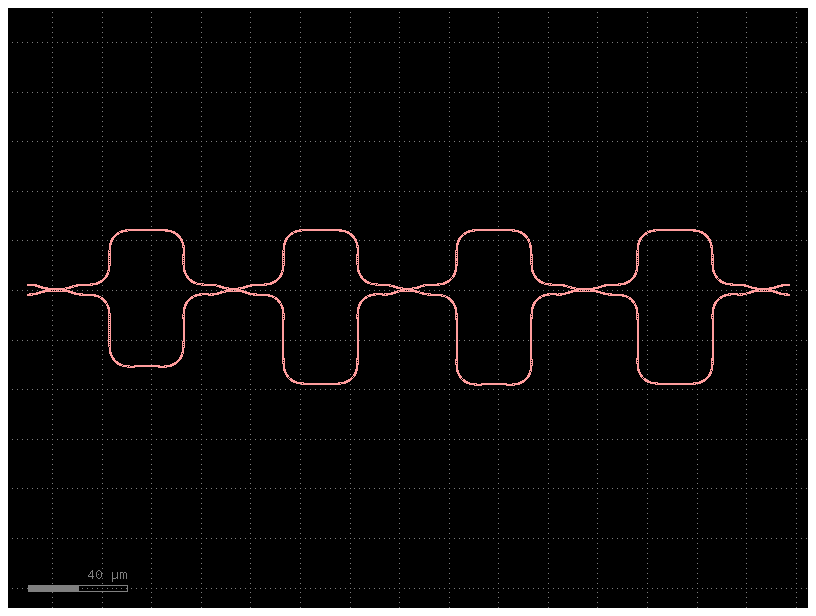

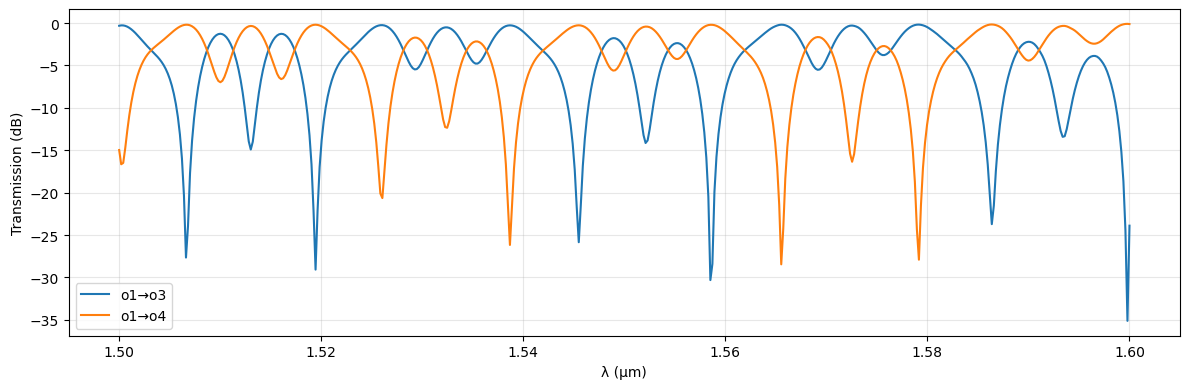

Available ports: [('o1', 'o1'), ('o1', 'o2'), ('o1', 'o4'), ('o1', 'o3'), ('o2', 'o1'), ('o2', 'o2'), ('o2', 'o4'), ('o2', 'o3'), ('o4', 'o1'), ('o4', 'o2'), ('o4', 'o4'), ('o4', 'o3'), ('o3', 'o1'), ('o3', 'o2'), ('o3', 'o4'), ('o3', 'o3')]


In [64]:
fix_lengths = [2.976, 2.976,]# 2.976, 2.976, 2.976]
# lengths = [2.976, 16.484, 16.59, 2.976, 1.178]
lengths =  [2.996, 0.115, 0.02, 2.996, 1.189]
layout = gf.components.mzi_lattice(
    coupler_gaps=(gap,) * len(lengths[:5]),
    coupler_lengths=tuple(lengths[:5]),
    delta_lengths=tuple([abs(x) for x in mzi_deltas[:4]]),
    cross_section='strip',
)
layout.plot()
# Your patch function
def patch_netlist(netlist, models, models_to_patch):
    instances = netlist["instances"]
    for name in instances:
        model = instances[name]
        if model["component"] in models_to_patch:
            component = model["component"]
            i = 0
            new_component = f"{component}_v{i}"
            while new_component in models:
                i += 1
                new_component = f"{component}_v{i}"
            settings = model["settings"]
            settings_filtered = {
                k: v
                for k, v in settings.items()
                if k in inspect.signature(models_to_patch[component]).parameters
            }
            models[new_component] = models_to_patch[model["component"]](
                **settings_filtered
            )
            del model["settings"]
            model["component"] = new_component
    return netlist, models

# Get recursive netlist
recursive_netlist = layout.get_netlist(recursive=True)

# Initialize models with your existing models
models = {
    "straight": straight_model, 
    "bend_euler": straight_model,#bend_model(cross_section='strip', wavelengths=wavelengths)
}

# Patch all sub-netlists in the recursive netlist
for component_name, netlist in recursive_netlist.items():
    if "instances" in netlist:
        netlist, models = patch_netlist(
            netlist=netlist,
            models=models,
            models_to_patch={"coupler": coupler_model}
        )

# Build SAX circuit with the patched recursive netlist
circuit, info = sax.circuit(netlist=recursive_netlist, models=models)

# Simulate
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
lda = np.linspace(1.5, 1.6, 500)
s = circuit(wl=lda)

# Plot results
ax.plot(lda, 20 * jnp.log10(jnp.abs(s[("o1", "o3")])), label="o1→o3")
ax.plot(lda, 20 * jnp.log10(jnp.abs(s[("o1", "o4")])), label="o1→o4")
# ax.plot(lda, 20 * jnp.log10(jnp.abs(s[("o2", "o3")])), label="o2→o3")
# ax.plot(lda, 20 * jnp.log10(jnp.abs(s[("o2", "o4")])), label="o2→o4")
# ax.set_ylim(-10, 0)
ax.set_xlabel("λ (µm)")
ax.set_ylabel("Transmission (dB)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Available ports:", list(s.keys()))

The inbulid mzi_lattice component does not allow neagtive delta length

SO have to build it from scratch using basic mzi component.    

# Cascade MZI WDM

In [158]:
import gdsfactory as gf
from gdsfactory.typings import ComponentSpec
import numpy as np

# @gf.cell(cache=False)
def cascade_mzi_wdm(
    num_stages: int = 4,
    delta_lengths: tuple = (14.3, 28.6, 28.6, 14.3),  # Your MZI deltas
    coupler_lengths: tuple = (2.976, 16.484, 16.59, 2.976, 1.178),  # 5 couplers
    gap: float = 0.15,
    length_x: float = 0.1,
    length_y: float = 2.0,
    cross_section: str = 'strip',
) -> gf.Component:
    """
    Create a cascade of MZIs with custom coupler lengths
    
    Args:
        num_stages: Number of MZI stages (default 4)
        delta_lengths: Tuple of delta lengths for each MZI
        coupler_lengths: Tuple of coupler lengths (need num_stages + 1)
        gap: Coupler gap
        length_y: Vertical length of MZI arms
        cross_section: Waveguide cross-section
        spacing: Spacing between MZI blocks
    
    Returns:
        Component with cascaded MZIs
    """
    c = gf.Component()
    
    # Validate inputs
    if len(delta_lengths) != num_stages:
        raise ValueError(f"Need {num_stages} delta lengths, got {len(delta_lengths)}")
    
    if len(coupler_lengths) != num_stages + 1:
        raise ValueError(f"Need {num_stages + 1} coupler lengths, got {len(coupler_lengths)}")
    
    print(f"Building {num_stages}-stage MZI cascade")
    print(f"Delta lengths: {delta_lengths}")
    print(f"Coupler lengths: {coupler_lengths}")
    
    mzi_refs = []
    
    for i in range(num_stages):
        # Create couplers for this MZI
        splitter_coupler = gf.components.coupler(
            gap=gap,
            length=coupler_lengths[i],
            cross_section=cross_section,
        )
        
        combiner_coupler = gf.components.coupler(
            gap=gap,
            length=coupler_lengths[i + 1],
            cross_section=cross_section,
        )
        
        # Create MZI with these specific couplers
        mzi = gf.components.mzi2x2_2x2_phase_shifter(
            delta_length=np.abs(delta_lengths[i]),
            length_x=length_x,
            length_y=length_y,
            splitter=splitter_coupler,
            combiner=combiner_coupler,
            straight_x_top=None,
            with_splitter=(i == 0),  # Only first MZI has input splitter
            cross_section=cross_section,
        )
        
        # Add reference to component
        # ref = c << mzi
        if delta_lengths[i]<0:
              # Work on the component
            mzi = mzi.copy()
            mzi = mzi.mirror_y()
            
            # Save ports correctly
            ports_temp = {
                'o1': mzi.ports['o1'],
                'o2': mzi.ports['o2'],
                'o3': mzi.ports['o3'],
                'o4': mzi.ports['o4'],
            }
            
            mzi.ports.clear()
            
            # Add swapped ports
            mzi.add_port('o1', port=ports_temp['o2'])
            mzi.add_port('o2', port=ports_temp['o1'])
            mzi.add_port('o3', port=ports_temp['o4'])
            mzi.add_port('o4', port=ports_temp['o3'])

        # NOW add it as reference
        ref = c << mzi  # ✓ Component already has correct ports
            
        # Position MZI
        if i == 0:
            ref.x = 0
            ref.y = 0
        else:
            # Connect to previous MZI
            prev_ref = mzi_refs[i - 1]
            ref.xmin = prev_ref.xmax
            ref.y = prev_ref.y
            ref.connect("o1", prev_ref.ports["o4"], allow_layer_mismatch=True)
            ref.connect("o2", prev_ref.ports["o3"], allow_layer_mismatch=True)
            
        mzi_refs.append(ref)

    # Add external ports
    c.add_port('o1', port=mzi_refs[0].ports['o1'])
    c.add_port('o2', port=mzi_refs[0].ports['o2'])
    c.add_port('o3', port=mzi_refs[-1].ports['o3'])
    c.add_port('o4', port=mzi_refs[-1].ports['o4'])
    
    return c


# parameters
# lda_c = 1.55
# ng = 4.2
# ne = 2.4
# gap = 0.15

# # Calculate deltas
# fsr = 5e-3
# ΔL = lda_c**2 / (fsr * ng)

# # Use symmetric pattern (all positive!)
# delta_lengths_stage1 = (ΔL, 2*ΔL, -2*ΔL, -ΔL)

# # Your optimized coupler lengths
# # coupler_lengths_stage1 = (2.976, 16.484, 16.59, 2.976, 1.178)
# coupler_lengths_stage1 = (2.996, 0.115, 0.02, 2.996, 1.189)
# # Build Stage 1 Block 1
# stage1_block1 = cascade_mzi_wdm(
#     num_stages=4,
#     delta_lengths=delta_lengths_stage1,
#     coupler_lengths=coupler_lengths_stage1,
#     gap=gap,
#     length_y=1.0,
#     length_x=0.5,
#     cross_section='strip',
# )

# stage1_block1.draw_ports()
# stage1_block1.plot()
# stage1_block1.show()

Building 4-stage MZI cascade
Delta lengths: (np.float64(14.099718968513637), np.float64(28.199437937027273), np.float64(-28.519559413624087), np.float64(-28.199437937027273))
Coupler lengths: (2.996, 0.115, 0.02, 2.996, 1.189)
2025-12-07 04:29:32.034 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 04:29:32.036 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.115.npz') already exists
2025-12-07 04:29:32.037 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.02.npz') already exists
2025-12-07 04:29:32.039 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulati

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component mzi_gdsfactorypcomponentspmzispmzi_DL28p519559413624087_38722597$3 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component mzi_gdsfactorypcomponentspmzispmzi_DL28p199437937027273_3f81c9d4$3 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)


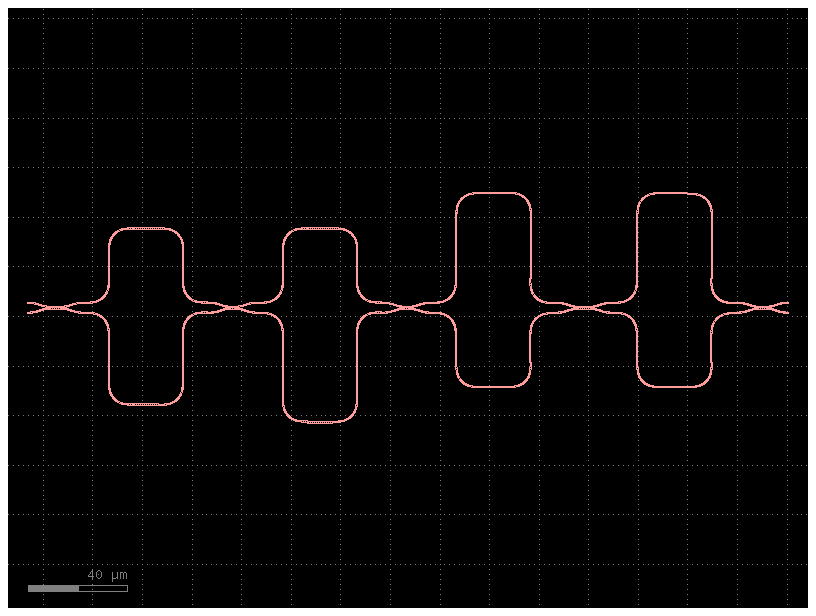

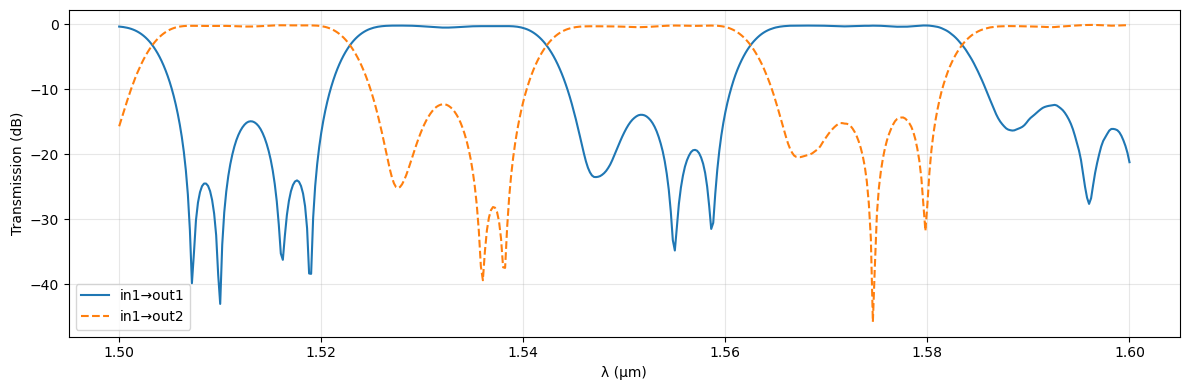

Available ports: [('o1', 'o1'), ('o1', 'o2'), ('o1', 'o3'), ('o1', 'o4'), ('o2', 'o1'), ('o2', 'o2'), ('o2', 'o3'), ('o2', 'o4'), ('o3', 'o1'), ('o3', 'o2'), ('o3', 'o3'), ('o3', 'o4'), ('o4', 'o1'), ('o4', 'o2'), ('o4', 'o3'), ('o4', 'o4')]


In [93]:
import inspect
import sax
import jax.numpy as jnp
import matplotlib.pyplot as plt
mzi_d = tuple(-x for x in mzi_deltas)
delta_lengths_stage1 = (ΔL, 2*ΔL, 2*ΔL, ΔL)
gap = 0.15
lengths =  [2.996, 0.115, 0.02, 2.996, 1.189]
layout = cascade_mzi_wdm(
    num_stages=4,
    delta_lengths=tuple((mzi_deltas[:4])),
    coupler_lengths=tuple(lengths[:5]),
    gap=gap,
    length_y=10.0,
    length_x=10.0,
    cross_section='strip',
).copy()
layout.plot()

# Your patch function
def patch_netlist(netlist, models, models_to_patch):
    """Patch a single netlist with custom models"""
    if "instances" not in netlist:
        return netlist, models
    
    instances = netlist["instances"]
    for name in instances:
        model = instances[name]
        component_type = model["component"]
        
        if component_type in models_to_patch:
            # Create unique model name
            i = 0
            new_component = f"{component_type}_v{i}"
            while new_component in models:
                i += 1
                new_component = f"{component_type}_v{i}"
            
            settings = model.get("settings", {})
            settings_filtered = {
                k: v
                for k, v in settings.items()
                if k in inspect.signature(models_to_patch[component_type]).parameters
            }
            
            models[new_component] = models_to_patch[component_type](**settings_filtered)
            
            if "settings" in model:
                del model["settings"]
            model["component"] = new_component
    
    return netlist, models

# Get recursive netlist (includes all sub-components)
recursive_netlist = layout.get_netlist(recursive=True)

# Initialize base models
models = {
    "straight": straight_model, 
    "bend_euler": straight_model,#bend_model(cross_section='strip', wavelengths=wavelengths),
}

# Patch couplers in ALL netlists
for component_name in recursive_netlist:
    recursive_netlist[component_name], models = patch_netlist(
        netlist=recursive_netlist[component_name],
        models=models,
        models_to_patch={"coupler": coupler_model}
    )

# Build models for all sub-components (bottom-up) - FIX: only take circuit, not tuple
component_order = [name for name in recursive_netlist if name != layout.name]

for component_name in component_order:
    if component_name not in models:
        try:
            # FIX: sax.circuit returns (circuit, info), we only need circuit
            sub_circuit, _ = sax.circuit(
                netlist=recursive_netlist[component_name],
                models=models
            )
            models[component_name] = sub_circuit  # Store only the circuit function
        except Exception as e:
            print(f"Could not build model for {component_name}: {e}")

# Finally build the top-level circuit
circuit, info = sax.circuit(
    netlist=recursive_netlist[layout.name],
    models=models
)

# Simulate
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
lda = np.linspace(1.5, 1.6, 501)
s = circuit(wl=lda)

# Plot results
ax.plot(lda, 20 * jnp.log10(jnp.abs(s[("o1", "o3")])), label="in1→out1")
ax.plot(lda, 20 * jnp.log10(jnp.abs(s[("o1", "o4")])), '--',label="in1→out2", )
# ax.set_ylim(-5, 0)
ax.set_xlabel("λ (µm)")
ax.set_ylabel("Transmission (dB)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Available ports:", list(s.keys()))

Stage 1 Suppression of parasitic modes


Building device with:
  Stage 1 coupler lengths: [2.996, 0.115, 0.02, 2.996, 1.189]
  Stage 2 coupler lengths: [2.996, 0.115, 0.02, 2.996, 1.189]
Building 4-stage MZI cascade
Delta lengths: (14.300595238095239, 28.601190476190478, -28.924107142857146, -28.601190476190478)
Coupler lengths: (2.996, 0.115, 0.02, 2.996, 1.189)
xmax_s1 = 153.65800000000002
Building 4-stage MZI cascade
Delta lengths: (14.300595238095239, 28.601190476190478, -28.924107142857146, -28.601190476190478)
Coupler lengths: (2.996, 0.115, 0.02, 2.996, 1.189)
xmax_s2 = 470.974
Building 4-stage MZI cascade
Delta lengths: (14.300595238095239, 28.601190476190478, -28.924107142857146, -28.601190476190478)
Coupler lengths: (2.996, 0.115, 0.02, 2.996, 1.189)

Adding terminators to unused ports...
Adding 2 terminators
Terminators added successfully

Device complete: 624.6 × 329.8 µm²
2025-12-07 04:36:15.302 | INFO     | kfactory.kcell:show:4059 - klive v0.4.1: Reloaded file '/home/ramprakash/Integrated_Tests/build/oas/32894

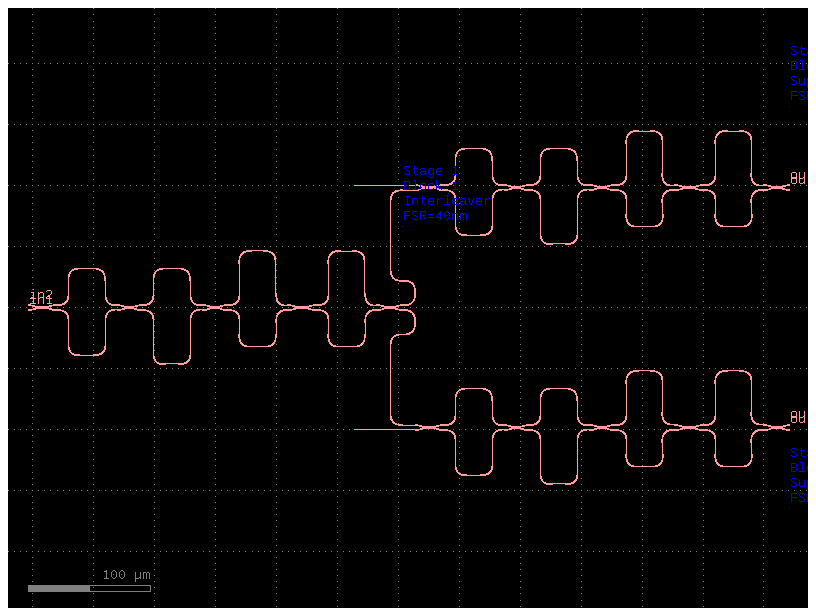

In [98]:
def build_stage1_cwdm(
    lda_c=1.55,
    ng=4.2,
    ne=2.4,
    gap=0.15,
    coupler_lengths_s1=None,  # For Stage 1
    coupler_lengths_s2=None,  # For Stage 2 (might be different)
    add_terminators=False,
    add_labels=True
):
    """
    Build complete 6-block CWDM demux
    
    Args:
        coupler_lengths_s1: List of 5 coupler lengths for Stage 1 blocks
        coupler_lengths_s2: List of 5 coupler lengths for Stage 2 blocks
    """
    if coupler_lengths_s1 is None:
        coupler_lengths_s1 = [2.976, 16.484, 16.59, 2.976, 1.178]
    
    if coupler_lengths_s2 is None:
        # If not specified, use same as Stage 1
        # But in reality, these might need optimization for FSR=80nm
        coupler_lengths_s2 = coupler_lengths_s1
    
    c = gf.Component()
    
    # Calculate MZI deltas
    fsr_s1 = 40e-3  # µm
    fsr_s2 = 80e-3  # µm
    
    ΔL_s1 = lda_c**2 / (fsr_s1 * ng)
    ΔL_s2 = lda_c**2 / (fsr_s2 * ng)
    Lπ = lda_c / (2 * ne)
    
    mzi_deltas_s1 = [
        ΔL_s1,
        2 * ΔL_s1,
       -Lπ - 2 * ΔL_s1,
        -2 * ΔL_s1,
    ]
    
    mzi_deltas_s2_high = [
        ΔL_s2,
        2 * ΔL_s2,
       - Lπ - 2 * ΔL_s2,
        -2 * ΔL_s2,
    ]
    
    mzi_deltas_s2_low = [
        ΔL_s2,
        2 * ΔL_s2,
       - Lπ/2 - 2 * ΔL_s2,  # π/2 shift
        -2 * ΔL_s2,
    ]
    
    print(f"\nBuilding device with:")
    print(f"  Stage 1 coupler lengths: {coupler_lengths_s1}")
    print(f"  Stage 2 coupler lengths: {coupler_lengths_s2}")
    
    # ============================================================
    # STAGE 1 - BLOCK 1 (Interleaver)
    # ============================================================
    # NOTE: mzi_lattice expects coupler_lengths with 4 elements, not 5!
    # The 5th coupler is the OUTPUT combiner, handled separately
    # So we only pass the first 4 coupler lengths
    
    s1_b1 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s1)),
        coupler_lengths=tuple(coupler_lengths_s1),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s1_b1_ref = c << s1_b1
    s1_b1_ref.x = 0
    s1_b1_ref.y = 0
    print('xmax_s1 =', s1_b1_ref.xmax)
    if add_labels:
        label1 = c.add_label(
            text="Stage 1\nBlock 1\nInterleaver\nFSR=40nm",
            position=(s1_b1_ref.x + s1_b1_ref.xsize/2, s1_b1_ref.ymax + 20),
            layer=(10, 0)  # Text layer
        )
    # ============================================================
    # STAGE 1 - BLOCK 21 (Suppression)
    # ============================================================
    s1_b21 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s1)),
        coupler_lengths=tuple(coupler_lengths_s1),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s1_b21_ref = c << s1_b21
    s1_b21_ref.xmin = s1_b1_ref.xmax + 10
    s1_b21_ref.ymin = s1_b1_ref.ymax + 5
    print('xmax_s2 =', s1_b21_ref.xmax)
    # Connect with routing
    B1r1 = gf.routing.route_single(
        c, s1_b1_ref.ports['o3'], s1_b21_ref.ports['o1'], cross_section='strip'
    )
    if add_labels:
        label2 = c.add_label(
            text="Stage 1\nBlock 2A\nSuppression\nFSR=40nm",
            position=(s1_b21_ref.x + s1_b21_ref.xsize/2, s1_b21_ref.ymax + 20),
            layer=(10, 0)
        )
    # =========================================================
    # STAGE 2 - BLOCK 22 
    # =========================================================
    s1_b22 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s1)),
        coupler_lengths=tuple(coupler_lengths_s1),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s1_b22_ref = c << s1_b22
    s1_b22_ref.xmin = s1_b1_ref.xmax + 10
    s1_b22_ref.ymax = s1_b1_ref.ymin - 5
    # print('xmax_s2 =', s1_b21_ref.xmax)
    # Connect with routing
    B1r2 = gf.routing.route_single(
        c, s1_b1_ref.ports['o4'], s1_b22_ref.ports['o2'], cross_section='strip'
    )
    if add_labels:
        label3 = c.add_label(
            text="Stage 1\nBlock 2B\nSuppression\nFSR=40nm",
            position=(s1_b22_ref.x + s1_b22_ref.xsize/2, s1_b22_ref.ymin - 20),
            layer=(10, 0)
        )
    
    c.add_port('in1', port=s1_b1_ref.ports['o1'])
    c.add_port('in2', port=s1_b1_ref.ports['o2'])
    c.add_port('out_top1', port=s1_b21_ref['o3'])
    c.add_port('out_top2', port=s1_b21_ref['o4'])
    c.add_port('out_bot1', port=s1_b22_ref['o3'])
    c.add_port('out_bot2', port=s1_b22_ref['o4'])

    if add_terminators:
        print("\nAdding terminators to unused ports...")
        
        # Create a set of all ports that are used (connected or named)
        used_ports = set()
        
        # # Add all named ports to used set
        # for port_name in c.ports.keys():
        #     used_ports.add(id(c.ports[port_name]))
        
        # Manually specify which ports to terminate based on your architecture
        # This is more reliable than trying to detect automatically
        
        ports_to_terminate = [
            s1_b21_ref.ports['o2'],
            # s1_b21_ref.ports['o3'],
            # s1_b22_ref.ports['o3'],
            s1_b22_ref.ports['o1'],  # This one is connected via route
        ]
        
        print(f"Adding {len(ports_to_terminate)} terminators")
        
        # Add terminator to each port
        for i, port in enumerate(ports_to_terminate):
            # Simple taper terminator
            terminator = gf.components.taper(
                length=50,
                width1=0.5,
                width2=0.1,
                cross_section='strip',
            )
            
            term_ref = c << terminator
            term_ref.connect('o1', port)
        
        print(f"Terminators added successfully")

    print(f"\nDevice complete: {c.xsize:.1f} × {c.ysize:.1f} µm²")
    
    return c

layout = build_stage1_cwdm(
    lda_c=1.55,
    ng=4.2,
    ne=2.4,
    gap=0.15,
    coupler_lengths_s1=lengths,
    coupler_lengths_s2=lengths,  # Might need optimization
    add_terminators=True,
)
layout.draw_ports()
layout.plot()
layout.show()

Getting recursive netlist...
Found 12 components in hierarchy

Step 1: Patching all couplers...
2025-12-07 05:37:56.976 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 05:37:56.977 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.115.npz') already exists
2025-12-07 05:37:56.979 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.02.npz') already exists
2025-12-07 05:37:56.980 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 05:37:56.982 | INFO   

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component Unnamed_245 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component Unnamed_248 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component Unnamed_251 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component mzi_gdsfactorypcomponentspmzispmzi_DL28p924107142857146_5b8db658$4 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **k


Built 11 components successfully
Remaining: 0

Step 3: Building top-level circuit...
✓ Top-level circuit built successfully!

Simulating...

Available ports: [('in1', 'in1'), ('in1', 'in2'), ('in1', 'out_top1'), ('in1', 'out_top2'), ('in1', 'out_bot1'), ('in1', 'out_bot2'), ('in2', 'in1'), ('in2', 'in2'), ('in2', 'out_top1'), ('in2', 'out_top2'), ('in2', 'out_bot1'), ('in2', 'out_bot2'), ('out_top1', 'in1'), ('out_top1', 'in2'), ('out_top1', 'out_top1'), ('out_top1', 'out_top2'), ('out_top1', 'out_bot1'), ('out_top1', 'out_bot2'), ('out_top2', 'in1'), ('out_top2', 'in2'), ('out_top2', 'out_top1'), ('out_top2', 'out_top2'), ('out_top2', 'out_bot1'), ('out_top2', 'out_bot2'), ('out_bot1', 'in1'), ('out_bot1', 'in2'), ('out_bot1', 'out_top1'), ('out_bot1', 'out_top2'), ('out_bot1', 'out_bot1'), ('out_bot1', 'out_bot2'), ('out_bot2', 'in1'), ('out_bot2', 'in2'), ('out_bot2', 'out_top1'), ('out_bot2', 'out_top2'), ('out_bot2', 'out_bot1'), ('out_bot2', 'out_bot2')]


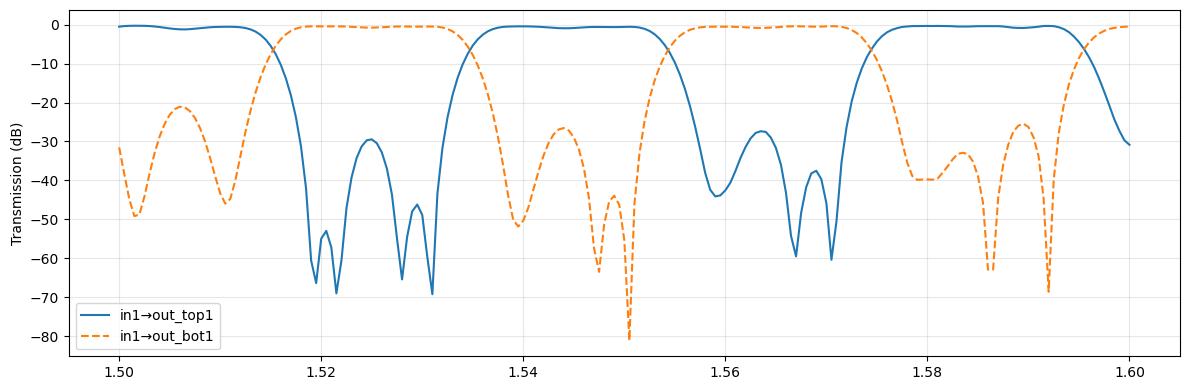


✓ Simulation complete!


In [110]:
def patch_netlist(netlist, models, models_to_patch):
    """Patch a single netlist with custom models"""
    if "instances" not in netlist:
        return netlist, models
    
    instances = netlist["instances"]
    for name in instances:
        model = instances[name]
        component_type = model["component"]
        
        if component_type in models_to_patch:
            i = 0
            new_component = f"{component_type}_v{i}"
            while new_component in models:
                i += 1
                new_component = f"{component_type}_v{i}"
            
            settings = model.get("settings", {})
            settings_filtered = {
                k: v
                for k, v in settings.items()
                if k in inspect.signature(models_to_patch[component_type]).parameters
            }
            
            models[new_component] = models_to_patch[component_type](**settings_filtered)
            
            if "settings" in model:
                del model["settings"]
            model["component"] = new_component
    
    return netlist, models

# Get recursive netlist
print("Getting recursive netlist...")
recursive_netlist = layout.get_netlist(recursive=True)

print(f"Found {len(recursive_netlist)} components in hierarchy")

# Initialize base models
models = {
    "straight": straight_model, 
    "bend_euler": straight_model,
    "taper": terminator_model,
}

# Step 1: Patch couplers in ALL netlists first
print("\nStep 1: Patching all couplers...")
for component_name in recursive_netlist:
    recursive_netlist[component_name], models = patch_netlist(
        netlist=recursive_netlist[component_name],
        models=models,
        models_to_patch={"coupler": coupler_model}
    )

# Step 2: Build models in correct dependency order
# We need to sort components by dependency depth
print("\nStep 2: Building component models in dependency order...")

def get_dependencies(comp_name, netlist_dict):
    """Get list of component types this component depends on"""
    if comp_name not in netlist_dict:
        return set()
    
    netlist = netlist_dict[comp_name]
    deps = set()
    
    for inst_name, inst_data in netlist.get('instances', {}).items():
        comp_type = inst_data.get('component', '')
        if comp_type and comp_type in netlist_dict:  # Only internal dependencies
            deps.add(comp_type)
    
    return deps

# Build dependency graph and sort
component_order = []
components_to_build = set(recursive_netlist.keys()) - {layout.name}
built_components = set(models.keys())

max_iterations = 100
iteration = 0

while components_to_build and iteration < max_iterations:
    iteration += 1
    made_progress = False
    
    for comp_name in list(components_to_build):
        # Get dependencies
        deps = get_dependencies(comp_name, recursive_netlist)
        
        # Check if all dependencies are built
        if deps.issubset(built_components):
            # All dependencies satisfied - build this component
            try:
                sub_circuit, _ = sax.circuit(
                    netlist=recursive_netlist[comp_name],
                    models=models
                )
                models[comp_name] = sub_circuit
                component_order.append(comp_name)
                built_components.add(comp_name)
                components_to_build.remove(comp_name)
                made_progress = True
                # print(f"  ✓ Built: {comp_name[:60]}...")
            except Exception as e:
                print(f"  ✗ Failed to build {comp_name[:60]}: {str(e)[:100]}")
                # Don't remove from components_to_build yet
    
    if not made_progress:
        print(f"\n  Warning: Could not make progress in iteration {iteration}")
        print(f"  Remaining components: {len(components_to_build)}")
        for comp in list(components_to_build)[:5]:
            deps = get_dependencies(comp, recursive_netlist)
            missing = deps - built_components
            print(f"    - {comp[:50]}")
            print(f"      Missing deps: {list(missing)[:3]}")
        break

print(f"\nBuilt {len(component_order)} components successfully")
print(f"Remaining: {len(components_to_build)}")

# Step 3: Build top-level circuit
print("\nStep 3: Building top-level circuit...")
try:
    circuit, info = sax.circuit(
        netlist=recursive_netlist[layout.name],
        models=models
    )
    print("✓ Top-level circuit built successfully!")
except Exception as e:
    print(f"✗ Failed to build top-level circuit:")
    print(f"  Error: {e}")
    
    # Debug output
    top_deps = get_dependencies(layout.name, recursive_netlist)
    missing = top_deps - set(models.keys())
    if missing:
        print(f"\n  Missing models for top-level:")
        for m in list(missing)[:5]:
            print(f"    - {m}")
    
    raise

# Simulate
print("\nSimulating...")

lda = np.linspace(1.50, 1.60, 201)
s = circuit(wl=lda)

print(f"\nAvailable ports: {list(s.keys())}")

# Plot results
plt.figure(figsize=(12, 4)) 
plt.plot(lda, 20 * jnp.log10(jnp.abs(s[("in1", "out_top1")])), label="in1→out_top1")
plt.plot(lda, 20 * jnp.log10(jnp.abs(s[("in1", "out_bot1")])), '--', label="in1→out_bot1")
plt.ylabel("Transmission (dB)")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.ylim(-60, 5)



plt.tight_layout()
plt.show()

print("\n✓ Simulation complete!")

The Finall showdown - Full 4-channel CWDM circuit

FIXME: The even channels are not working - Cause to optimize the DC for these wavelengths


Building device with:
  Stage 1 coupler lengths: [2.996, 0.115, 0.02, 2.996, 1.189]
  Stage 2 coupler lengths: [2.996, 0.115, 0.02, 2.996, 1.189]
Building 4-stage MZI cascade
Delta lengths: (14.300595238095239, 28.601190476190478, -28.924107142857146, -28.601190476190478)
Coupler lengths: (2.996, 0.115, 0.02, 2.996, 1.189)
xmax_s1 = 153.65800000000002
Building 4-stage MZI cascade
Delta lengths: (14.300595238095239, 28.601190476190478, -28.924107142857146, -28.601190476190478)
Coupler lengths: (2.996, 0.115, 0.02, 2.996, 1.189)
xmax_s2 = 470.974
Building 4-stage MZI cascade
Delta lengths: (14.300595238095239, 28.601190476190478, -28.924107142857146, -28.601190476190478)
Coupler lengths: (2.996, 0.115, 0.02, 2.996, 1.189)
Building 4-stage MZI cascade
Delta lengths: (7.1502976190476195, 14.300595238095239, -14.623511904761905, -14.300595238095239)
Coupler lengths: (2.996, 0.115, 0.02, 2.996, 1.189)
Building 4-stage MZI cascade
Delta lengths: (7.1502976190476195, 14.300595238095239, -14.4

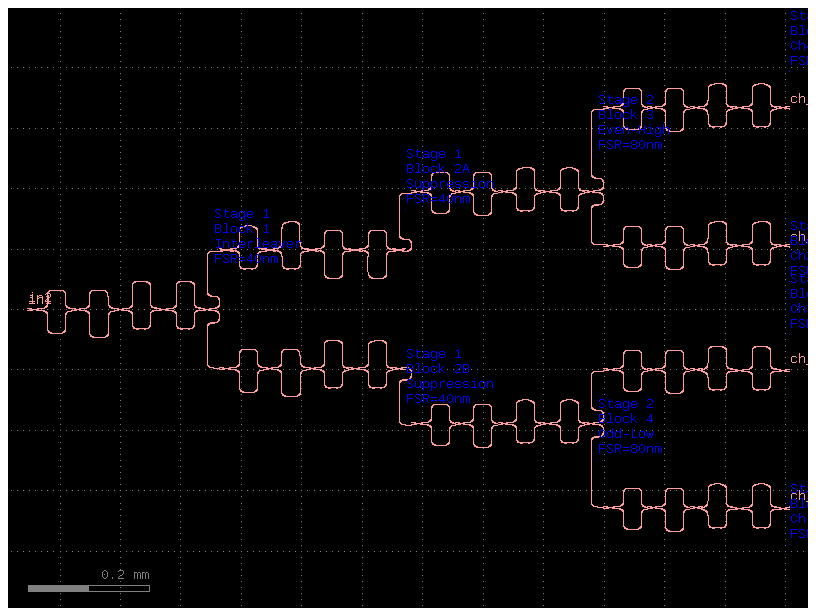

In [159]:
# FIXME: The even channels are not working - Cause to optimize the DC for these wavelengths

def build_complete_cwdm_with_exact_couplers(
    lda_c=1.55,
    ng=4.2,
    ne=2.4,
    gap=0.15,
    coupler_lengths_s1=None,  # For Stage 1
    coupler_lengths_s2=None,  # For Stage 2 (might be different)
    add_terminators=False,
    add_labels=True
):
    """
    Build complete 6-block CWDM demux
    
    Args:
        coupler_lengths_s1: List of 5 coupler lengths for Stage 1 blocks
        coupler_lengths_s2: List of 5 coupler lengths for Stage 2 blocks
    """
    if coupler_lengths_s1 is None:
        coupler_lengths_s1 = [2.976, 16.484, 16.59, 2.976, 1.178]
    
    if coupler_lengths_s2 is None:
        # If not specified, use same as Stage 1
        # But in reality, these might need optimization for FSR=80nm
        coupler_lengths_s2 = coupler_lengths_s1
    
    c = gf.Component()
    
    # Calculate MZI deltas
    fsr_s1 = 40e-3  # µm
    fsr_s2 = 80e-3  # µm
    
    ΔL_s1 = lda_c**2 / (fsr_s1 * ng)
    ΔL_s2 = lda_c**2 / (fsr_s2 * ng)
    Lπ = lda_c / (2 * ne)
    
    mzi_deltas_s1 = [
        ΔL_s1,
        2 * ΔL_s1,
        - Lπ - 2 * ΔL_s1,
        -2 * ΔL_s1,
    ]
    
    mzi_deltas_s2_high = [
        ΔL_s2,
        2 * ΔL_s2,
       - Lπ - 2 * ΔL_s2,
        -2 * ΔL_s2,
    ]
    
    mzi_deltas_s2_low = [
        ΔL_s2,
        2 * ΔL_s2,
       - Lπ/2 - 2 * ΔL_s2,  # π/2 shift
        -2 * ΔL_s2,
    ]
    
    print(f"\nBuilding device with:")
    print(f"  Stage 1 coupler lengths: {coupler_lengths_s1}")
    print(f"  Stage 2 coupler lengths: {coupler_lengths_s2}")
    
    # ============================================================
    # STAGE 1 - BLOCK 1 (Interleaver)
    # ============================================================
    # NOTE: mzi_lattice expects coupler_lengths with 4 elements, not 5!
    # The 5th coupler is the OUTPUT combiner, handled separately
    # So we only pass the first 4 coupler lengths
    
    s1_b1 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s1)),
        coupler_lengths=tuple(coupler_lengths_s1),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s1_b1_ref = c << s1_b1
    s1_b1_ref.x = 0
    s1_b1_ref.y = 0
    print('xmax_s1 =', s1_b1_ref.xmax)
    if add_labels:
        label1 = c.add_label(
            text="Stage 1\nBlock 1\nInterleaver\nFSR=40nm",
            position=(s1_b1_ref.x + s1_b1_ref.xsize/2, s1_b1_ref.ymax + 20),
            layer=(10, 0)  # Text layer
        )
    # ============================================================
    # STAGE 1 - BLOCK 21 (Suppression)
    # ============================================================
    s1_b21 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s1)),
        coupler_lengths=tuple(coupler_lengths_s1),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        ).mirror_y()
    s1_b21_ref = c << s1_b21
    s1_b21_ref.xmin = s1_b1_ref.xmax + 10
    s1_b21_ref.ymin = s1_b1_ref.ymax + 5
    print('xmax_s2 =', s1_b21_ref.xmax)
    # Connect with routing
    B1r1 = gf.routing.route_single(
        c, s1_b1_ref.ports['o3'], s1_b21_ref.ports['o2'], cross_section='strip'
    )
    if add_labels:
        label2 = c.add_label(
            text="Stage 1\nBlock 2A\nSuppression\nFSR=40nm",
            position=(s1_b21_ref.x + s1_b21_ref.xsize/2, s1_b21_ref.ymax + 20),
            layer=(10, 0)
        )
    # =========================================================
    # STAGE 1 - BLOCK 22 
    # =========================================================
    s1_b22 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s1)),
        coupler_lengths=tuple(coupler_lengths_s1),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s1_b22_ref = c << s1_b22
    s1_b22_ref.xmin = s1_b1_ref.xmax + 10
    s1_b22_ref.ymax = s1_b1_ref.ymin - 5
    # print('xmax_s2 =', s1_b21_ref.xmax)
    # Connect with routing
    B1r2 = gf.routing.route_single(
        c, s1_b1_ref.ports['o4'], s1_b22_ref.ports['o2'], cross_section='strip'
    )
    if add_labels:
        label3 = c.add_label(
            text="Stage 1\nBlock 2B\nSuppression\nFSR=40nm",
            position=(s1_b22_ref.x + s1_b22_ref.xsize/2, s1_b22_ref.ymin - 20),
            layer=(10, 0)
        )
    # ============================================================
    # STAGE 2 even - BLOCK 3
    # ============================================================
    s2e_b3 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s2_high)),
        coupler_lengths=tuple(coupler_lengths_s2),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s2e_b3_ref = c << s2e_b3
    s2e_b3_ref.xmin = s1_b21_ref.xmax + 10
    s2e_b3_ref.ymin = s1_b21_ref.ymax + 10
    
    r3 = gf.routing.route_single(
        c, s1_b21_ref.ports['o3'], s2e_b3_ref.ports['o1'], cross_section='strip'
    )
    if add_labels:
        label4 = c.add_label(
            text="Stage 2\nBlock 3\nEven-High\nFSR=80nm",
            position=(s2e_b3_ref.x + s2e_b3_ref.xsize/2, s2e_b3_ref.ymax + 20),
            layer=(10, 0)
        )
    # ============================================================
    # STAGE 2 odd - BLOCK 4
    # ============================================================
    s2o_b4 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s2_low)),
        coupler_lengths=tuple(coupler_lengths_s2),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s2o_b4_ref = c << s2o_b4
    s2o_b4_ref.xmin = s1_b22_ref.xmax + 10
    s2o_b4_ref.ymax = s1_b22_ref.ymin - 5
    
    r4 = gf.routing.route_single(
        c, s1_b22_ref.ports['o3'], s2o_b4_ref.ports['o1'], cross_section='strip'
    )
    if add_labels:
        label5 = c.add_label(
            text="Stage 2\nBlock 4\nOdd-Low\nFSR=80nm",
            position=(s2o_b4_ref.x + s2o_b4_ref.xsize/2, s2o_b4_ref.ymin - 20),
            layer=(10, 0)
        )
    # ============================================================
    # STAGE 2 HIGH - BLOCKS 5 & 6
    # ============================================================
    s2h_b5 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s2_high)),
        coupler_lengths=tuple(coupler_lengths_s2),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s2h_b5_ref = c << s2h_b5
    s2h_b5_ref.xmin = s2e_b3_ref.xmax + 10
    s2h_b5_ref.ymin = s2e_b3_ref.ymax + 60
    
    r5 = gf.routing.route_single(
        c, s2e_b3_ref.ports['o3'], s2h_b5_ref.ports['o1'], cross_section='strip'
    )
    if add_labels:
        label6 = c.add_label(
            text="Stage 2\nBlock 5\nCh4 Demux\nFSR=80nm",
            position=(s2h_b5_ref.x + s2h_b5_ref.xsize/2, s2h_b5_ref.ymax + 20),
            layer=(10, 0)
        )
    
    s2h_b6 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s2_high)),
        coupler_lengths=tuple(coupler_lengths_s2),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s2h_b6_ref = c << s2h_b6
    s2h_b6_ref.xmin = s2e_b3_ref.xmax + 10
    s2h_b6_ref.ymax = s2e_b3_ref.ymin - 10
    
    r6 = gf.routing.route_single(
        c, s2e_b3_ref.ports['o4'], s2h_b6_ref.ports['o2'], cross_section='strip'
    )
    if add_labels:
        label7 = c.add_label(
            text="Stage 2\nBlock 6\nCh2 Demux\nFSR=80nm",
            position=(s2h_b6_ref.x + s2h_b6_ref.xsize/2, s2h_b6_ref.ymin - 20),
            layer=(10, 0)
        )
    
    # ============================================================
    # STAGE 2 LOW - BLOCKS 7 & 8
    # ============================================================
    s2l_b7 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s2_high)),
        coupler_lengths=tuple(coupler_lengths_s2),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s2l_b7_ref = c << s2l_b7
    s2l_b7_ref.xmin = s2o_b4_ref.xmax + 10
    s2l_b7_ref.ymin = s2o_b4_ref.ymax + 10
    
    r7 = gf.routing.route_single(
        c, s2o_b4_ref.ports['o3'], s2l_b7_ref.ports['o1'], cross_section='strip'
    )
    if add_labels:
        label8 = c.add_label(
            text="Stage 2\nBlock 7\nCh3 Demux\nFSR=80nm",
            position=(s2l_b7_ref.x + s2l_b7_ref.xsize/2, s2l_b7_ref.ymax + 20),
            layer=(10, 0)
        )

    s2l_b8 = cascade_mzi_wdm(
        num_stages=4,
        delta_lengths=tuple((mzi_deltas_s2_high)),
        coupler_lengths=tuple(coupler_lengths_s2),
        gap=gap,
        length_y=10.0,
        length_x=10.0,
        cross_section='strip',
        )
    s2l_b8_ref = c << s2l_b8
    s2l_b8_ref.xmin = s2o_b4_ref.xmax + 10
    s2l_b8_ref.ymax = s2o_b4_ref.ymin - 60
    
    r8 = gf.routing.route_single(
        c, s2o_b4_ref.ports['o4'], s2l_b8_ref.ports['o2'], cross_section='strip'
    )
    if add_labels:
        label9 = c.add_label(
            text="Stage 2\nBlock 8\nCh1 Demux\nFSR=80nm",
            position=(s2l_b8_ref.x + s2l_b8_ref.xsize/2, s2l_b8_ref.ymin - 20),
            layer=(10, 0)
        )
    # Add ports
    c.add_port('in1', port=s1_b1_ref.ports['o1'])
    c.add_port('in2', port=s1_b1_ref.ports['o2'])
    c.add_port('ch_1', port=s2l_b8_ref.ports['o3'])
    c.add_port('ch_2', port=s2h_b6_ref.ports['o4'])
    c.add_port('ch_3', port=s2l_b7_ref.ports['o3'])
    c.add_port('ch_4', port=s2h_b5_ref.ports['o4'])
    

    # ============================================================
    # ADD TERMINATORS TO UNUSED PORTS
    # ============================================================
    if add_terminators:
        print("\nAdding terminators to unused ports...")
        
        # Create a set of all ports that are used (connected or named)
        used_ports = set()
        
        # # Add all named ports to used set
        # for port_name in c.ports.keys():
        #     used_ports.add(id(c.ports[port_name]))
        
        # Manually specify which ports to terminate based on your architecture
        # This is more reliable than trying to detect automatically
        
        ports_to_terminate = [
            s1_b21_ref.ports['o2'],
            s1_b21_ref.ports['o3'],
            s1_b22_ref.ports['o3'],
            s1_b22_ref.ports['o1'],  # This one is connected via route
            s2e_b3_ref.ports['o2'],
            s2o_b4_ref.ports['o2'],
            s2h_b5_ref.ports['o2'],
            s2h_b5_ref.ports['o3'],
            s2h_b6_ref.ports['o4'],
            s2h_b6_ref.ports['o1'],  # Connected
            s2l_b7_ref.ports['o2'],
            s2l_b7_ref.ports['o3'],
            s2l_b8_ref.ports['o4'],
        ]
        
        print(f"Adding {len(ports_to_terminate)} terminators")
        
        # Add terminator to each port
        for i, port in enumerate(ports_to_terminate):
            # Simple taper terminator
            terminator = gf.components.taper(
                length=50,
                width1=0.5,
                width2=0.1,
                cross_section='strip',
            )
            
            term_ref = c << terminator
            term_ref.connect('o1', port)
        
        print(f"Terminators added successfully")
        
    print(f"\nDevice complete: {c.xsize:.1f} × {c.ysize:.1f} µm²")
    
    return c

# Build device
layout = build_complete_cwdm_with_exact_couplers(
    lda_c=1.55,
    ng=4.2,
    gap=0.15,
    ne=2.4,
    coupler_lengths_s1=lengths,
    coupler_lengths_s2=lengths,  # Might need optimization
    add_terminators=False,
)
layout.draw_ports()
layout.plot()
layout.show()

Getting recursive netlist...


/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component Unnamed_890 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component Unnamed_893 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component Unnamed_896 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component Unnamed_899 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/pyt

Found 32 components in hierarchy

Step 1: Patching all couplers...
2025-12-07 06:47:56.068 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 06:47:56.070 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.115.npz') already exists
2025-12-07 06:47:56.072 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_0.02.npz') already exists
2025-12-07 06:47:56.075 | INFO     | gplugins.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:148 - Simulation PosixPath('/home/ramprakash/Integrated_Tests/test_outputs/fitted_dc_2.996.npz') already exists
2025-12-07 06:47:56.076 | INFO     | gplugins.gmeep.write_spar

/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component mzi_gdsfactorypcomponentspmzispmzi_DL14p623511904761905_b81c5581$92 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)
/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/gdsfactory/get_netlist.py:707: UserWarning: Component mzi_gdsfactorypcomponentspmzispmzi_DL14p300595238095239_6a30077c$118 has no function_name. Using component.name instead.
  netlist = get_netlist_func(component, **kwargs)



Built 31 components successfully
Remaining: 0

Step 3: Building top-level circuit...
✓ Top-level circuit built successfully!

Simulating...

Available ports: [('in1', 'in1'), ('in1', 'in2'), ('in1', 'ch_4'), ('in1', 'ch_2'), ('in1', 'ch_3'), ('in1', 'ch_1'), ('in2', 'in1'), ('in2', 'in2'), ('in2', 'ch_4'), ('in2', 'ch_2'), ('in2', 'ch_3'), ('in2', 'ch_1'), ('ch_4', 'in1'), ('ch_4', 'in2'), ('ch_4', 'ch_4'), ('ch_4', 'ch_2'), ('ch_4', 'ch_3'), ('ch_4', 'ch_1'), ('ch_2', 'in1'), ('ch_2', 'in2'), ('ch_2', 'ch_4'), ('ch_2', 'ch_2'), ('ch_2', 'ch_3'), ('ch_2', 'ch_1'), ('ch_3', 'in1'), ('ch_3', 'in2'), ('ch_3', 'ch_4'), ('ch_3', 'ch_2'), ('ch_3', 'ch_3'), ('ch_3', 'ch_1'), ('ch_1', 'in1'), ('ch_1', 'in2'), ('ch_1', 'ch_4'), ('ch_1', 'ch_2'), ('ch_1', 'ch_3'), ('ch_1', 'ch_1')]


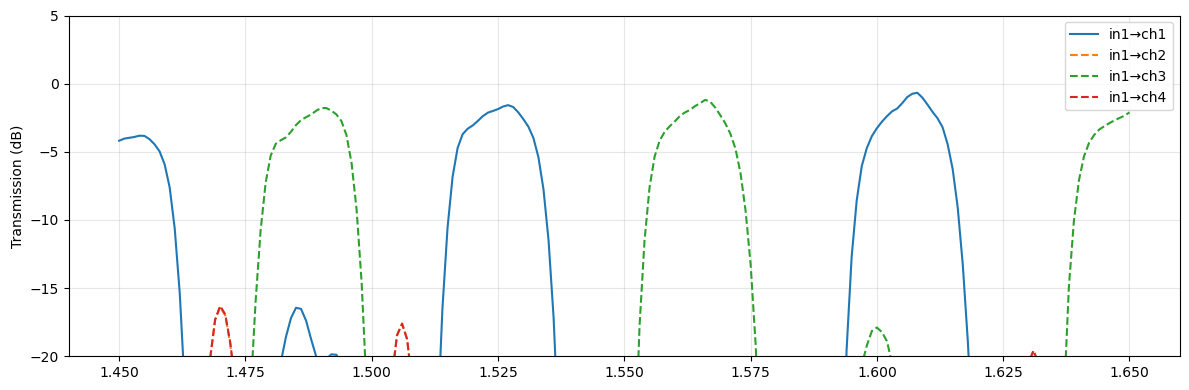


✓ Simulation complete!


In [160]:
# FIXME: The even channels are not working - Cause to optimize the DC for these wavelengths

def patch_netlist(netlist, models, models_to_patch):
    """Patch a single netlist with custom models"""
    if "instances" not in netlist:
        return netlist, models
    
    instances = netlist["instances"]
    for name in instances:
        model = instances[name]
        component_type = model["component"]
        
        if component_type in models_to_patch:
            i = 0
            new_component = f"{component_type}_v{i}"
            while new_component in models:
                i += 1
                new_component = f"{component_type}_v{i}"
            
            settings = model.get("settings", {})
            settings_filtered = {
                k: v
                for k, v in settings.items()
                if k in inspect.signature(models_to_patch[component_type]).parameters
            }
            
            models[new_component] = models_to_patch[component_type](**settings_filtered)
            
            if "settings" in model:
                del model["settings"]
            model["component"] = new_component
    
    return netlist, models

# Get recursive netlist
print("Getting recursive netlist...")
recursive_netlist = layout.get_netlist(recursive=True)

print(f"Found {len(recursive_netlist)} components in hierarchy")

# Initialize base models
models = {
    "straight": straight_model, 
    "bend_euler": straight_model,
    "taper": terminator_model,
}

# Step 1: Patch couplers in ALL netlists first
print("\nStep 1: Patching all couplers...")
for component_name in recursive_netlist:
    recursive_netlist[component_name], models = patch_netlist(
        netlist=recursive_netlist[component_name],
        models=models,
        models_to_patch={"coupler": coupler_model}
    )

# Step 2: Build models in correct dependency order
# We need to sort components by dependency depth
print("\nStep 2: Building component models in dependency order...")

def get_dependencies(comp_name, netlist_dict):
    """Get list of component types this component depends on"""
    if comp_name not in netlist_dict:
        return set()
    
    netlist = netlist_dict[comp_name]
    deps = set()
    
    for inst_name, inst_data in netlist.get('instances', {}).items():
        comp_type = inst_data.get('component', '')
        if comp_type and comp_type in netlist_dict:  # Only internal dependencies
            deps.add(comp_type)
    
    return deps

# Build dependency graph and sort
component_order = []
components_to_build = set(recursive_netlist.keys()) - {layout.name}
built_components = set(models.keys())

max_iterations = 100
iteration = 0

while components_to_build and iteration < max_iterations:
    iteration += 1
    made_progress = False
    
    for comp_name in list(components_to_build):
        # Get dependencies
        deps = get_dependencies(comp_name, recursive_netlist)
        
        # Check if all dependencies are built
        if deps.issubset(built_components):
            # All dependencies satisfied - build this component
            try:
                sub_circuit, _ = sax.circuit(
                    netlist=recursive_netlist[comp_name],
                    models=models
                )
                models[comp_name] = sub_circuit
                component_order.append(comp_name)
                built_components.add(comp_name)
                components_to_build.remove(comp_name)
                made_progress = True
                # print(f"  ✓ Built: {comp_name[:60]}...")
            except Exception as e:
                print(f"  ✗ Failed to build {comp_name[:60]}: {str(e)[:100]}")
                # Don't remove from components_to_build yet
    
    if not made_progress:
        print(f"\n  Warning: Could not make progress in iteration {iteration}")
        print(f"  Remaining components: {len(components_to_build)}")
        for comp in list(components_to_build)[:5]:
            deps = get_dependencies(comp, recursive_netlist)
            missing = deps - built_components
            print(f"    - {comp[:50]}")
            print(f"      Missing deps: {list(missing)[:3]}")
        break

print(f"\nBuilt {len(component_order)} components successfully")
print(f"Remaining: {len(components_to_build)}")

# Step 3: Build top-level circuit
print("\nStep 3: Building top-level circuit...")
try:
    circuit, info = sax.circuit(
        netlist=recursive_netlist[layout.name],
        models=models
    )
    print("✓ Top-level circuit built successfully!")
except Exception as e:
    print(f"✗ Failed to build top-level circuit:")
    print(f"  Error: {e}")
    
    # Debug output
    top_deps = get_dependencies(layout.name, recursive_netlist)
    missing = top_deps - set(models.keys())
    if missing:
        print(f"\n  Missing models for top-level:")
        for m in list(missing)[:5]:
            print(f"    - {m}")
    
    raise

# Simulate
print("\nSimulating...")

lda = np.linspace(1.45, 1.65, 201)
s = circuit(wl=lda)

print(f"\nAvailable ports: {list(s.keys())}")

# Plot results
plt.figure(figsize=(12, 4)) 
plt.plot(lda, 20 * jnp.log10(jnp.abs(s[("in1", "ch_1")])), label="in1→ch1")
plt.plot(lda, 20 * jnp.log10(jnp.abs(s[("in1", "ch_2")])), '--', label="in1→ch2")
plt.plot(lda, 20 * jnp.log10(jnp.abs(s[("in1", "ch_3")])), '--', label="in1→ch3")
plt.plot(lda, 20 * jnp.log10(jnp.abs(s[("in1", "ch_4")])), '--', label="in1→ch4")
plt.ylabel("Transmission (dB)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-20, 5)



plt.tight_layout()
plt.show()

print("\n✓ Simulation complete!")